In [101]:
import numpy as np


In [104]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [105]:
import matplotlib.pyplot as plt

# MLP

In [6]:
def get_minibatch(batch_size = 32, x = None, y = None):
    siz = x.shape[0]
    for j in range(0,siz,batch_size):
        mini_x = x[j:j+batch_size, :] # shape = (n, 25)
        mini_y = y[j:j+batch_size, :] # shape = (n,  1)

        yield mini_x, mini_y

In [7]:
class Linear():
    def __init__(self, ip_nodes = 25, op_nodes = 10, parameters = None, reg = False, power = 2, rp = 1):
        
        self.x = None
        self.z = None
        self.ip_nodes = ip_nodes
        self.op_nodes = op_nodes
        
        # print("parameters : ", type(parameters))
        
        if len(np.array(parameters).shape) == 0: # parameters contains no information
            self.weights = np.random.randn(op_nodes, ip_nodes) # / np.sqrt(self.ip_nodes) #shape = (10, 25)
            self.bias = np.zeros((1, op_nodes)) # shape = (1, 1)
        else:
            self.weights = parameters[0]
            self.bias = parameters[1]
        
        # print(self.weights)
        
        #gradients
        self.dz_by_dw = None
        self.dz_by_db = None
        self.dz_by_dx = self.weights
        
        self.dloss_by_dw = None
        self.dloss_by_db = None
        self.dloss_by_dx = None
    
    def get_parameters(self):
        # print("came here")
        # print([self.weights, self.bias])
        return [self.weights, self.bias]
        
    def forward(self, x, print_data = False): # shape = (n, 25)
        self.x = x
        # print("x.shape : ", x.shape, "self.weights : ", self.weights.shape)
        self.z = x@self.weights.T + self.bias # shape = (n,25)@(10,25).T + n*(1,10)  -> (n, 10)
        return self.z
    

        
    def calculate_grads_wrt_loss(self, dloss_by_dz, print_data=False): #(n, 10)
        
        # print("insise calculate grads wrt loss")
        # print("dloss_by_dz shape : ", dloss_by_dz.shape)
        
        dloss_by_dz = dloss_by_dz[:,np.newaxis,:] #(n,1,10)
        
        self.dloss_by_dx = (dloss_by_dz@self.weights[np.newaxis,:,:])[:,0,:] # (n,1,10)@(1,10,25)->(n,1,25)->(n,25)
        
        self.dloss_by_db = np.average(dloss_by_dz, axis = 0)*self.dz_by_db # (1,10) 
        
        dloss_by_dz = np.repeat(dloss_by_dz[:,np.newaxis,:,:], self.z.shape[-1], axis = 1) # (n,10,1,10)
        
        self.dloss_by_dw = (dloss_by_dz@self.dz_by_dw).squeeze(axis = 2) #(n,10,1,10)@(n,10,10,25)->(n,10,1,25)->(n,10,25)   
        
        self.dloss_by_dw = np.average(self.dloss_by_dw, axis = 0) #(10,25)        
        
        
    def calculate_grads_local(self):
        # self.x shape = (n, 25)
        x_temp = np.copy(self.x)[:, np.newaxis, np.newaxis, :]# shape = (n, 25) -> (n, 1, 1, 25)
        
        r = np.repeat(np.expand_dims(np.eye(self.op_nodes), axis = 2), self.ip_nodes, axis=2) # shape = (10, 10, 25)
        
        f = np.repeat(np.expand_dims(r, axis = 0), self.x.shape[0], axis = 0) # shape = (n, 10, 10, 25)
        
        self.dz_by_dw = f*x_temp # shape = (n,10,10,25)
        
        self.dz_by_db = np.ones((1, self.op_nodes)) # shape = (1, 10)
        self.dz_by_dx = np.repeat(self.weights[np.newaxis,:,:], self.x.shape[0], axis = 0)
        
        
    def calculate_gradients_usual(self, dloss_by_dz): # calculates gradient of the usual part
        self.calculate_grads_local() # 4th dimensional matrix of shape (n, 10, 10, 25)
        self.calculate_grads_wrt_loss(dloss_by_dz)

    
    def backward_and_get_gradients(self, dloss_by_dz, lr = 0.01,reg = False, rp = 0.01,power = 1, print_data=False): #shape  (n, 1, 10)
        
        self.calculate_gradients_usual(dloss_by_dz)
        
        # print("dloss_by_dz.shape : ", dloss_by_dz.shape, "dz_by_dw : ", self.dz_by_dw.shape)        
        
        if reg == True:
            self.weights -= lr*(self.dloss_by_dw)  + rp*np.sum((np.abs(self.weights))**power)# (10,25)
            self.bias -= lr*(self.dloss_by_db) + rp*np.sum((np.abs(self.bias))**power) # shape = (1,10)*(1,10) -> (1,10)
        
        else:
            self.weights -= lr*(self.dloss_by_dw) # (10,25)
            self.bias -= lr*(self.dloss_by_db)# shape = (1,10)*(1,10) -> (1,10)
        

        if print_data:
            print("linear layer")
            print("dloss_by_dw : ", self.dloss_by_dw.shape)
            print("dloss_by_dw : ", self.dloss_by_dw)


            print("dloss_by_db : ", self.dloss_by_db.shape)
            print("dloss_by_db : ", self.dloss_by_db)
            
            print("dloss_by_dx : ", self.dloss_by_dx.shape)
            print("dloss_by_dx : ", self.dloss_by_dx)
            
            
            print("updated weights :", self.weights.shape)
            print("updated weights : : ", self.weights)
            
            print("updated bias : ", self.bias.shape)
            print("updated bias :", self.bias)
            
        # , self.dloss_by_dw, self.dloss_by_db (10,25) (1,10)
        return self.dloss_by_dx # (n,25) 

In [8]:
class Softmax():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None
        self.dloss_by_dz = None
     
    def softmax(self, z, print_data=False):  # x.shape  = (n, 10)
        
        if print_data:
            print("z", z.shape)
            print(z)
        
        # if z.shape[0] > 1:
        #     m = np.average(z, axis=0, keepdims = True) # shape = (n, 10)
        # else:
        #     m = np.zeros((1,z.shape[-1]))
        
        m = np.max(z)

        # if print_data:
        #     print("m", m.shape)
        #     print(m)
        
        exponent = np.exp(z-m) # shape = (n, 10)
        
        if  print_data:
            print("exponent", exponent.shape)
            print(exponent)
        
        sum_ = np.sum(exponent, axis = 1, keepdims = True)
        if print_data:
            print("sum_ is 0 in softmax for denominator")
            print(sum_)
        
        op = exponent / sum_  # shape = (n, 10)/(n, 1) -> (n, 10)
        
        if print_data:
            print("op", op.shape)
            print(op)
        
        return  op
        
    def forward(self, z, print_data=False):
        self.z = z # (n, 10)
        self.a = self.softmax(z)
        return self.a # shape = (n, 10)
    
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False):
        
        """
        example:
        >>> a = np.array([[1,2,3],
                          [4,5,6],
                          [4,5,6],
                          [4,5,6]])
        
        >>> cross_derivatives = np.expand_dims(a, axis = 2)@ np.expand_dims(a, axis = 1)
        >>> cross_derivatives 
                array([[[ 1,  2,  3],
                        [ 2,  4,  6],
                        [ 3,  6,  9]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]]])
        
        >>> same_derivatives = np.expand_dims(a, axis = 2)*np.eye(a.shape[1])
        >>> same_derivates 
            array([[[1., 0., 0.],
                    [0., 2., 0.],
                    [0., 0., 3.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]]])
        
        """
        
        a = self.softmax(self.z, print_data=print_data) # (n, 10)
        
        # same_derivatives = np.expand_dims(a, axis = 2)*np.eye(a.shape[1]) # da1_by_dz1, da2_by_dz2 like that  shape = (n, 10, 10)
        
        # cross_derivatives = np.expand_dims(a, axis = 2)@np.expand_dims(a, axis = 1) # da1_by_dz2, like that terms
        
        # da_by_dz = np.sum(same_derivatives - cross_derivatives, axis = 2) # shape = (n, 10, 10) -> (n, 10)
                               
        # da_by_dz = same_derivatives - cross_derivatives # shape = (n, 10, 10)
        
        
        temp1 = np.repeat(np.expand_dims(-a, axis = 2), a.shape[1], axis = 2) \
              + np.repeat(np.expand_dims(np.eye(a.shape[1]), axis = 0), a.shape[0], axis = 0)
        
        if print_data:
            print("inside softmax")
        
        
        # print("temp 1", temp1.shape)
        
        self.da_by_dz = a[:,:,np.newaxis]*temp1
        
        
        # da_by_dz = da_by_dz.transpose(0,2,1)
        
        # print("da_by_dz", self.da_by_dz.shape)
        
        dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,10) -> (n,1,10)
        
        if print_data :
            # print("dloss_by_dx : ", dloss_by_dx.shape)
            # print("dloss_by_dx : ", dloss_by_dx)
            
            print("dloss_by_da : ", dloss_by_da.shape)
            print("dloss_by_da : ", dloss_by_da)
            
            
            print("da_by_dz : ", self.da_by_dz.shape)
            print("da_by_dz : ", self.da_by_dz)
        
        
        self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # (n,1,10)@(n,10,10) -> (n,1,10) -> (n, 10)
        
        if print_data :

            # print("dloss_by_dx : ", dloss_by_dx.shape)
            # print("dloss_by_dx : ", dloss_by_dx)
            
            print("self.dloss_by_dz : ", self.dloss_by_dz.shape)
            print("self.dloss_by_dz : ", self.dloss_by_dz)
        
        
        # self.dloss_by_dz = np.repeat(self.dloss_by_dz[:,np.newaxis,:,:], self.z.shape[-1], axis = 1) # (n,10,1,10)
        
        
        
        return self.dloss_by_dz # shape = (n,10)

In [9]:
class Sigmoid():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None # local loss
        self.dloss_by_dz = None # global loss
        
        
    def sigmoid(self, z, print_data=False):
        self.z = z #shape = (n,k) k is number of nodes
        
        self.a = np.sigmoid(z) # (n,k)
        
    
    def forward(self, z, print_data=False):
        self.sigmoid(z)
        return self.a # shape = (n,k)
        
         
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False): # shape of dloss_by_da = (n, k)
        
        if print_data:
            print("inside sigmoid")
        
        # dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,k) -> (n, 1, k)
        
        # lengthy method
        # a_temp = self.a[:,:,np.newaxis]
        # da_by_dz = a_temp*np.repeat(np.eye(self.z.shape[-1])[np.newaxis,:,:], self.z.shape[0], axis = 0) # (n,k,1)*(n,k,k) -> (n,k,k)
        # self.da_by_dz = np.array(da_by_dz >= 0, dtype = int)
        # self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # final shape  = (n,1,k) -> (n,k)
        
        
        # shortcut
        self.da_by_dz = self.a*(1-self.a) # shape = (n,k)
        
        self.dloss_by_dz = self.da_by_dz * self.dloss_by_da # (n,k)*(n,k) -> (n,k)
        
        
        
        return self.dloss_by_dz  # (n,k)

In [10]:
class ReLU():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None # local loss
        self.dloss_by_dz = None # global loss
        
        
    def relu(self, z, print_data=False):
        self.z = z #shape = (n,k) k is number of nodes
        self.a = np.maximum(z,0) # (n,k)
        
    
    def forward(self, z, print_data=False):
        self.relu(z)
        return self.a # shape = (n,k)
        
         
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False): # shape of dloss_by_da = (n, k)
        
        if print_data:
            print("inside relu")
        
        # dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,k) -> (n, 1, k)
        
        # lengthy method
        # a_temp = self.a[:,:,np.newaxis]
        # da_by_dz = a_temp*np.repeat(np.eye(self.z.shape[-1])[np.newaxis,:,:], self.z.shape[0], axis = 0) # (n,k,1)*(n,k,k) -> (n,k,k)
        # self.da_by_dz = np.array(da_by_dz >= 0, dtype = int)
        # self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # final shape  = (n,1,k) -> (n,k)
        
        
        # shortcut
        self.da_by_dz = np.array(self.a >= 0, dtype = int) # shape = (n,k)
        
        self.dloss_by_dz = self.da_by_dz * dloss_by_da # (n,k)*(n,k) -> (n,k)
        
        
        
        return self.dloss_by_dz  # (n,k)

In [11]:
class Matured_Layer():
    def __init__(self, activation = 'relu', ip_nodes = 25, op_nodes = 10, parameters = None, reg = False, power = 2, rp = 1):
        self.x = None
        
        self.a = None
        
        self.activation_type = activation
        self.linear = Linear(ip_nodes = ip_nodes, op_nodes = op_nodes, parameters = parameters, reg = reg,power = power,rp = rp)
        
        
        if activation == 'relu':
            self.activation = ReLU()
        elif activation == 'sigmoid':
            self.activation = Sigmoid()
        elif activation == 'softmax':
            self.activation = Softmax()
        elif activation == 'linear':
            self.activation = None
    
    def forward(self, x, print_data = False):
        self.x = x
        if self.activation_type == 'linear':
            self.a = self.linear.forward(self.x)
            if print_data:
                print("forward pass after linear layer:", self.a)
        else:
            temp = self.linear.forward(self.x)
            self.a = self.activation.forward(temp)
            if print_data:
                print("forward pass after linear layer:", temp)
                print("forward pass after activation layer:", self.a) 
        return self.a
    
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False):
        if self.activation_type == 'linear':
            dloss_by_dx = self.linear.backward_and_get_gradients(dloss_by_da, lr = lr, print_data=print_data)
        else:
            dloss_by_dx = self.linear.backward_and_get_gradients(
                                self.activation.backward_and_get_gradients(dloss_by_da, lr = lr, \
                                                                           print_data=print_data),\
                                lr = lr,\
                                print_data=print_data)
        return dloss_by_dx

In [12]:
class Model():
    def __init__(self, ip_nodes = 25, hidden_nodes = [], op_nodes = 10,\
                 intermediate_activations = 'relu', final_activation = 'softmax',\
                 parameters = None, reg = False, power = 2, rp = 1):
        self.x = None
        self.a = None
        self.n_nodes = [ip_nodes] + hidden_nodes + [op_nodes]
        
        self.layers = []
        self.final_activation = final_activation
        
        if parameters is None:
            parameters = [None] * len(self.n_nodes)
        
        # print(index, i, j)
        #print(parameters)
        #print(self.n_nodes)
        for index,tup in enumerate(zip(self.n_nodes[:-2],self.n_nodes[1:-1])):
            i = tup[0]
            j = tup[1]
            #print(index, i, j)
            self.layers.append(Matured_Layer(ip_nodes = i, op_nodes = j, \
                                              activation = 'relu', \
                                             parameters = parameters[index],\
                                             reg = reg, power = power, rp = rp))
            
        self.layers += [Matured_Layer(ip_nodes = self.n_nodes[-2], op_nodes = self.n_nodes[-1],\
                                      activation = final_activation, parameters = parameters[-1])]
        self.final_parameters = parameters
        
        
    def get_parameters(self):
        # saving
        # temp_weights = model.layer1.weights
        # temp_bias = model.layer1.bias

        # with open('weights.pkl', 'wb') as f:
        #     pkl.dump(temp_weights, f)

        # with open('bias.pkl', 'wb') as f:
        #     pkl.dump(temp_bias, f)
        
        # reading
        # try:
        #     with open('weights.pkl', 'rb') as f:
        #         self.weights = pkl.load(f)

        #     with open('bias.pkl', 'rb') as f:
        #         self.bias = pkl.load(f)

        # except:
        #     self.weights = np.random.randn(op_nodes, ip_nodes) #shape = (10, 25)
        #     self.bias = np.zeros((1, op_nodes)) # shape = (1, 10)
        
        # b = np.load('a.npy', allow_pickle=True)
        
        return self.final_parameters
        
    
    def forward(self, x, print_data = False): # shape = (n, 25)
        self.x = x # shape = (n, 25)
        
        self.a = self.x
        for layer in self.layers:
            self.a = layer.forward(self.a, print_data = print_data)
            if print_data:
                print("forward pass after matured layer:", self.a)
        
        return self.a
        
    
    def round_the_ops(self,a): # shape = (n, 10)
            """
            task: makes the max element 1 and rest 0
            
            """
            maxes = np.max(a, axis = 1, keepdims = True) # (n ,10) -> (n, 1)
            return np.array(a==maxes, dtype = int) # shape = (n, 10)
    
    def fit(self, generator = get_minibatch, x = None, y = None, \
            n_epochs = 1, lr = 0.01, batch_size = 32, print_data=False, reg = False, power = 2, rp = 1,\
           end_after_first_iteration = False, stop_after_iterations = 10): # train_x shape  = (n, 25) , (n, 10)
        
        self.final_parameters = []
        
        def confusion_matrix(y, y_hats):
            """
            Confusion matrix whose i-th row and j-th column entry indicates the 
            number of samples with true label being i-th class and predicted 
            label being j-th class.
            """
            #y = y.copy().squeeze().astype(int)
            #y_hats = y_hats.copy().squeeze().astype(int)

            n_classes = y.shape[1]
            cm = np.zeros((n_classes,n_classes))

            # tuples = np.array(tuple(zip(y,y_hats)))
            for i in range(y.shape[0]):
                cm[np.argmax(y[i]), np.argmax(y_hats[i])] += 1

            return cm


        def ohe(y): # one hot encoding, shape of y = (n,1) # each  element represents a class 
            """
            example:
            >>> r = np.random.randint(0,10,(4,1))
            >>> r
                array([[7],
                       [2],
                       [1],
                       [0]])
            >>> t= np.eye(10)[r]
            >>> t.shape
                (4, 1, 10)
            >>> t1 = t[:,0,:]
            >>> t1.shape
            array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
            
            random_syntax [repeated 'eyes'] :
            >>> np.array([np.eye(2)]*4)
                array([[[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]]])
            """
            
            return np.eye(self.n_nodes[-1])[y][:,0,:]
        

        
        def get_loss(a, y): # shapes a = (n, 10), y = (n, 10) # 10 output nodes
            
            if self.final_activation == "softmax": # cross entropy loss
                loss = np.average(-1*np.sum(y*np.log(a), axis = 1)) #scalar
            elif self.final_activation == 'linear': # mean squared error loss
                loss = np.average((a-y)*(a-y), axis = 0, keepdims = True) # row vector shape  = (1, k) # k op nodes
                
            if print_data:
                print("loss : ",loss.shape, loss)
            
            return loss  
        
        
        def get_dloss_by_da(a, y): # shape of a & y = (n, 10)
            if self.final_activation == 'softmax':
                dloss_by_da = -y/a # shape = (n, 10)/(n, 10) -> (n, 10)
            elif self.final_activation == 'linear':
                dloss_by_da = 2*(a-y) # shape = (n, 10)
            return dloss_by_da  # shape = (n, 10)
        
        training_accuracies = []
        training_losses = []
        lr_backup = lr
        break_flag = False
        loss = None
        for i in range(n_epochs):
            lr = lr_backup
            for iter_num, data in enumerate(generator(x = x, y = y, batch_size = batch_size)):
                
                try:
                    if training_losses[-1] > training_losses[-2]:
                        lr = lr/10
                except:...
                
                mini_x = data[0] # shape = (n, 25)
                if self.final_activation == 'softmax':
                    mini_y = ohe(data[1].astype(int)) # shape = (n, 10)
                elif self.final_activation == 'linear':
                    mini_y = data[1]
                
                if print_data :
                    print(iter_num,"\n\n\n")
                    print("mini_x", mini_x, "mini_y", mini_y)

                # forward pass
                a = self.forward(mini_x, print_data = print_data)
                
                
                if self.final_activation == 'softmax':
                    y_hat = self.round_the_ops(a) # shape = (n, 10) -> (n, 10)
                elif self.final_activation == 'linear':
                    y_hat = a
                
                
                loss = get_loss(a, mini_y)
                
                if print_data:
                    print("y_hat : ", y_hat, "loss : ", loss, "mini_y : ", mini_y)
                
                
                # calculate the gradients
                
                dloss_by_da = get_dloss_by_da(a, mini_y) # shape = (n, 1, 10)
                
                if print_data :
                    print("dloss_by_da : ", dloss_by_da.shape)
                    print("dloss_by_da : ", dloss_by_da)
                
                #update weights
                
                temp_grad = dloss_by_da
                for layer in reversed(self.layers):
                    temp_grad = layer.backward_and_get_gradients(temp_grad, lr = lr, print_data=print_data)
                    
                    if print_data :
                        print("temp_grad : ", temp_grad.shape)
                        print("temp_grad : ", temp_grad)
                    
                # book keeping
                training_losses.append(loss)
                
                #print(mini_x.shape, mini_y.shape)
                #print(y_hat)
                #print(mini_y)
                if self.final_activation == 'softmax':
                    cm = confusion_matrix(y_hat, mini_y)
                    tr = np.trace(cm)
                    cnt = np.sum(cm)
                    training_accuracies.append((tr/cnt)*100)
                
                
                if end_after_first_iteration:
                    break
                
                if np.isnan(loss.any()):
                    break
                print(iter_num)
                if iter_num > stop_after_iterations:
                    break_flag = True
                    break
            # mlp_model_params = mlp_model.get_parameters()
            #print(model_params[0][0][0][0])
            np.save('mlp_tfidf/parameters_{i}.npy', self.get_parameters())
            
            if break_flag:
                break
            if np.isnan(loss.any()):
                    break
            
            
            if end_after_first_iteration:
                break
        for matured_layer in self.layers:
            #print("came here 2")
            #print(matured_layer.linear.get_parameters())
            self.final_parameters.append(matured_layer.linear.get_parameters())
        
        self.final_parameters = np.array(self.final_parameters, dtype = object)
        
        return training_losses, training_accuracies
        

In [13]:
np.random.rand(10,2,3).transpose(0,2,1).shape

(10, 3, 2)

In [14]:
dloss_by_dZ = None

In [15]:
if dloss_by_dZ is not None:
    dloss_by_dZ = np.concatenate((dloss_by_dZ, np.random.rand(1,3,2)), axis = 0)
    
else:
    dloss_by_dZ = np.random.rand(1,3,2)

In [16]:
dloss_by_dZ.shape

(1, 3, 2)

In [17]:
dloss_by_dZ

array([[[0.86670332, 0.35555056],
        [0.1696905 , 0.48970107],
        [0.32239213, 0.63297256]]])

In [18]:
dloss_by_dZ[0,:,:].shape

(3, 2)

# Self Attention

In [19]:
# incomplete
class SelfAttention:
    def __init__(self, dim):
        self.Wq = np.random.rand(1, dim, dim)
        self.Wk = np.random.rand(1, dim, dim)
        self.Wv = np.random.rand(1, dim, dim)
        
    def forward(self, X):
        self.X = X # shape = (n, T, dim) (n, 10,64)
        self.Q = X @ (self.Wq.transpose(0,2,1)) # shape = (n, T, dim) @ (1, dim, dim) => (n, T, dim) -> (n, 10,64)
        self.K = X @ (self.Wk.transpose(0,2,1)) # shape = (n, T, dim) @ (1, dim, dim) => (n, T, dim) -> (n, 10,64)
        self.V = X @ (self.Wv.transpose(0,2,1)) # shape = (n, T, dim) @ (1, dim, dim) => (n, T, dim) -> (n, 10,64)
        
        # print(self.Q.shape, self.K.transpose(0,2,1).shape)
        
        self.Z = (self.Q @ self.K.transpose(0,2,1)) / np.sqrt(self.K.shape[-1]) # shape = (n, T, dim) @ (n, dim, T) -> (n, T, T)
        
        # softmax
        self.Z = self.Z - np.max(self.Z)
        self.A = np.exp(self.Z) / np.sum(np.exp(self.Z), axis=-1, keepdims=True) # shape = (n, T, T)

        self.Y = self.A @ self.V # shape = (n, T, T) @ (n, T, dim) -> (n, T, dim)
        
        # print("forward pass")
        # print("Wq.shape ", self.Wq.shape) # (1, 64, 64)
        # print("Wk.shape ", self.Wk.shape)
        # print("Wv.shape ", self.Wv.shape)


        # print("X.shape ", self.X) # (1, 10, 64)
        # print("Q.shape ", self.Q)
        # print("K.shape ", self.K)
        # print("V.shape ", self.V)

        # print("Z.shape", self.Z)
        # print("A.shape", self.A)
        # print("Y.shape", self.Y) allok
        
        # print('V', self.V)

        
        return self.Y
    
    
    def get_softmax_backward_single(self, dloss_by_da, Z):
        a = np.exp(Z) / np.sum(np.exp(Z), axis=-1, keepdims=True) # (n, 10)
        
        # same_derivatives = np.expand_dims(a, axis = 2)*np.eye(a.shape[1]) # da1_by_dz1, da2_by_dz2 like that  shape = (n, 10, 10)
        
        # cross_derivatives = np.expand_dims(a, axis = 2)@np.expand_dims(a, axis = 1) # da1_by_dz2, like that terms
        
        # da_by_dz = np.sum(same_derivatives - cross_derivatives, axis = 2) # shape = (n, 10, 10) -> (n, 10)
                               
        # da_by_dz = same_derivatives - cross_derivatives # shape = (n, 10, 10)
        
        
        temp1 = np.repeat(np.expand_dims(-a, axis = 2), a.shape[1], axis = 2) \
              + np.repeat(np.expand_dims(np.eye(a.shape[1]), axis = 0), a.shape[0], axis = 0)
        
        
        self.da_by_dz = a[:,:,np.newaxis]*temp1
        
        
        # da_by_dz = da_by_dz.transpose(0,2,1)
        
        # print("da_by_dz", self.da_by_dz.shape)
        
        dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,10) -> (n,1,10)
        
        self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # (n,1,10)@(n,10,10) -> (n,1,10) -> (n, 10)
        
        return (self.dloss_by_dz*(1/np.sqrt(Z.shape[-1])))[np.newaxis, :, :] # shape = (1,n,10)
        
        
    def get_softmax_backward(self, dloss_by_dA, Z):
        dloss_by_dZ = None
        for i in range(Z.shape[0]):
            if dloss_by_dZ is not None:
                dloss_by_dZ = np.concatenate((dloss_by_dZ, self.get_softmax_backward_single(dloss_by_dA[i,:,:], Z[i,:,:])), axis = 0)
            else:
                dloss_by_dZ = self.get_softmax_backward_single(dloss_by_dA[i,:,:], Z[i,:,:])
        
        return dloss_by_dZ
        
    def get_loss(self, dloss_by_dY,Y, A, V_, print_data = False): #returns gradient of Y wrt A. i.e, grad of 2nd matrix wrt 3rd matrix
        """
        shapes : dloss_by_dY = (T, dim), Y = (n, T, dim),  A = (n, T, T), V = (n, T, dim)
        """
        dloss_by_dA = np.zeros_like(A)
        
        
        V = np.repeat(V_, Y.shape[0],  axis = 0)
        
        if print_data:
            print('dloss_by_dY.shape', dloss_by_dY.shape)
            print('Y.shape', Y.shape)
            print('A.shape', A.shape)
            print('V.shape', V.shape)
        
        
        for i in range(Y.shape[0]): # 0->n
            for j in range(Y.shape[1]): # 0->T
                for k in range(Y.shape[2]): # 0->dim
                    temp1 = np.zeros_like(A[0])
                    # print("V[i,:,k] ", V[i,:,k]) #.transpose(0,2,1)[0])
                    # print("temp1[j,:] ", temp1[j,:])
                    #if print_data:
                    #    print("V.shape", V.shape)
                    temp1[j,:] += V[i,:,k]
                    # print("dloss_by_dY.shape ", dloss_by_dY.shape,"temp1.shape ", temp1.shape,\
                    #       "dloss_by_dA.shape", dloss_by_dA.shape)
                    dloss_by_dA += dloss_by_dY[i,j,k]*temp1
                # print(temp1)
        
        # print(dloss_by_dA.shape)
        return dloss_by_dA
    
    
    def backward_and_get_gradients(self, dY, lr = 0.01):
        # print("backward pass")
        dloss_by_dY = dY
        print("dloss_by_dY.shape ", dloss_by_dY.shape)
        print("self.Y.shape ", self.Y.shape)
        dloss_by_dA = self.get_loss(dloss_by_dY, self.Y, self.A, self.V) # 
        
        #print("dloss_by_dA.shape ", dloss_by_dA)#.shape)
        
        dloss_by_dV = self.get_loss(dloss_by_dY.transpose(0,2,1), self.Y.transpose(0,2,1),\
                                    self.V.transpose(0,2,1), self.A.transpose(0,2,1)).transpose(0,2,1)
        
        #print("dloss_by_dV.shape ", dloss_by_dV)#.shape)
        
        
        dloss_by_dZ = self.get_softmax_backward(dloss_by_dA, self.Z)
        #print("dloss_by_dZ.shape ", dloss_by_dZ)#.shape)
        
        dloss_by_dQ = self.get_loss(dloss_by_dZ, self.Z, self.Q, self.K.transpose(0,2,1))/ np.sqrt(self.K.shape[-1])
        
        #print("dloss_by_dQ.shape ", dloss_by_dQ)#.shape)
        
        dloss_by_dK = self.get_loss(dloss_by_dZ.transpose(0,2,1), self.Z.transpose(0,2,1), \
                                    self.K, self.Q.transpose(0,2,1))/ np.sqrt(self.K.shape[-1])
        
        #print("dloss_by_dK.shape ", dloss_by_dK)#.shape)
        
        
        #print("Wv shape :", self.Wv.shape)
        #print("self.X.shape", self.X.shape)
        
        dloss_by_dWv = self.get_loss(dloss_by_dV.transpose(0,2,1), self.V.transpose(0,2,1), \
                                     self.Wv, self.X.transpose(0,2,1)).transpose(0,2,1)# / np.sqrt(self.K.shape[-1])
        #print("dloss_by_dWv.shape ", dloss_by_dWv)#.shape) ok
        
        dloss_by_dWk = self.get_loss(dloss_by_dK.transpose(0,2,1), self.K.transpose(0,2,1), \
                                     self.Wk, self.X.transpose(0,2,1)).transpose(0,2,1) / np.sqrt(self.K.shape[-1])/ np.sqrt(self.K.shape[-1])#/ np.sqrt(self.K.shape[-1])
        #print("dloss_by_dWk.shape ", dloss_by_dWk)#.shape)
        
        dloss_by_dWq = self.get_loss(dloss_by_dQ.transpose(0,2,1), self.Q.transpose(0,2,1), \
                                     self.Wq, self.X.transpose(0,2,1)).transpose(0,2,1)/ np.sqrt(self.K.shape[-1])/ np.sqrt(self.K.shape[-1])#/ np.sqrt(self.K.shape[-1])
        #print("dloss_by_dWq.shape ", dloss_by_dWq)# )
        
        
        
        dloss_by_dX = self.get_loss(dloss_by_dQ, self.Q, self.X, self.Wq.transpose(0,2,1), print_data = False).transpose(0,2,1) \
                    + self.get_loss(dloss_by_dK, self.K, self.X, self.Wk.transpose(0,2,1), print_data = False).transpose(0,2,1) \
                    + self.get_loss(dloss_by_dV, self.V, self.X, self.Wv.transpose(0,2,1), print_data = False).transpose(0,2,1)
        
        #print("dloss_by_dX.shape ", dloss_by_dX)#.shape)
        
        
        # dA = dY @ self.Wv.T
        # dZ = self.A * (dA - np.sum(dA * self.A, axis=-1, keepdims=True))

        # dWq = np.dot(self.X.T, np.dot(dZ, self.Wk.T))
        # dWk = np.dot(self.X.T, np.dot(dZ.T, self.Wq).T)
        # dWv = np.dot(self.X.T, np.dot(dY.T, self.A).T)
        
        self.Wq -= lr * dloss_by_dWq
        self.Wk -= lr * dloss_by_dWk
        self.Wv -= lr * dloss_by_dWv
        
        return dloss_by_dX

In [20]:
# # Usage
# X = np.random.rand(2, 10, 1) # 1 sample with 10 sequences of dimension 64
# sa = SelfAttention(1)
# Y = sa.forward(X)
# print(Y.shape)

# dY = np.random.rand(*Y.shape)
# op = sa.backward_and_get_gradients(dY)

In [21]:
class Attention_MLP():
    def __init__(self, dim=1, T=100,op_nodes = 42 ):
        self.x = None
        self.n_nodes = [T,80,op_nodes]
        self.final_activation = 'softmax'
        self.attn_dim = dim
        self.attn = SelfAttention(self.attn_dim)
        self.layer1 = Matured_Layer(ip_nodes = self.n_nodes[0], op_nodes = self.n_nodes[1], activation = 'relu')
        self.layer2 = Matured_Layer(ip_nodes = self.n_nodes[1], op_nodes = self.n_nodes[2], activation = 'softmax')
    
    def forward(self, x):
        self.x = x[:,:,np.newaxis]
        self.x1 = self.attn.forward(self.x)
        self.x2 = self.x1[:,:,0]
        # print("self.x2 ", self.x2.shape)
        self.a1 = self.layer1.forward(self.x2)
        self.a2 = self.layer2.forward(self.a1)
        return self.a2    
    
    
    def round_the_ops(self,a): # shape = (n, 10)
        """
        task: makes the max element 1 and rest 0

        """
        maxes = np.max(a, axis = 1, keepdims = True) # (n ,10) -> (n, 1)
        return np.array(a==maxes, dtype = int) # shape = (n, 10)
        
        
    def fit(self, generator = get_minibatch, x = None, y = None, \
            n_epochs = 1, lr = 0.01, batch_size = 32, print_data=False, reg = False, power = 2, rp = 1,\
           end_after_first_iteration = False, stop_after_iterations = 10): # train_x shape  = (n, 25) , (n, 10)
        
        
        def confusion_matrix(y, y_hats):
            """
            Confusion matrix whose i-th row and j-th column entry indicates the 
            number of samples with true label being i-th class and predicted 
            label being j-th class.
            """
            #y = y.copy().squeeze().astype(int)
            #y_hats = y_hats.copy().squeeze().astype(int)

            n_classes = y.shape[1]
            cm = np.zeros((n_classes,n_classes))

            # tuples = np.array(tuple(zip(y,y_hats)))
            for i in range(y.shape[0]):
                cm[np.argmax(y[i]), np.argmax(y_hats[i])] += 1

            return cm


        def ohe(y): # one hot encoding, shape of y = (n,1) # each  element represents a class 
            """
            example:
            >>> r = np.random.randint(0,10,(4,1))
            >>> r
                array([[7],
                       [2],
                       [1],
                       [0]])
            >>> t= np.eye(10)[r]
            >>> t.shape
                (4, 1, 10)
            >>> t1 = t[:,0,:]
            >>> t1.shape
            array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
            
            random_syntax [repeated 'eyes'] :
            >>> np.array([np.eye(2)]*4)
                array([[[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]]])
            """
            
            return np.eye(self.n_nodes[-1])[y][:,0,:]
        

        
        def get_loss(a, y): # shapes a = (n, 10), y = (n, 10) # 10 output nodes
            
            if self.final_activation == "softmax": # cross entropy loss
                loss = np.average(-1*np.sum(y*np.log(a), axis = 1)) #scalar
            elif self.final_activation == 'linear': # mean squared error loss
                loss = np.average((a-y)*(a-y), axis = 0, keepdims = True) # row vector shape  = (1, k) # k op nodes
                
            if print_data:
                print("loss : ",loss.shape, loss)
            
            return loss  
        
        
        def get_dloss_by_da(a, y): # shape of a & y = (n, 10)
            if self.final_activation == 'softmax':
                dloss_by_da = -y/a # shape = (n, 10)/(n, 10) -> (n, 10)
            elif self.final_activation == 'linear':
                dloss_by_da = 2*(a-y) # shape = (n, 10)
            return dloss_by_da  # shape = (n, 10)
        
        training_accuracies = []
        training_losses = []
        lr_backup = lr
        break_flag = False
        loss = None
        for i in range(n_epochs):
            lr = lr_backup
            for iter_num, data in enumerate(generator(x = x, y = y, batch_size = batch_size)):
                
                try:
                    if training_losses[-1] > training_losses[-2]:
                        lr = lr/10
                except:...
                
                mini_x = data[0] # shape = (n, 25)
                if self.final_activation == 'softmax':
                    mini_y = ohe(data[1].astype(int)) # shape = (n, 10)
                elif self.final_activation == 'linear':
                    mini_y = data[1]
                
                if print_data :
                    print(iter_num,"\n\n\n")
                    print("mini_x", mini_x, "mini_y", mini_y)

                # forward pass
                a = self.forward(mini_x)
                
                
                if self.final_activation == 'softmax':
                    y_hat = self.round_the_ops(a) # shape = (n, 10) -> (n, 10)
                elif self.final_activation == 'linear':
                    y_hat = a
                
                
                loss = get_loss(a, mini_y)
                
                if print_data:
                    print("y_hat : ", y_hat, "loss : ", loss, "mini_y : ", mini_y)
                
                
                # calculate the gradients
                
                dloss_by_da2 = get_dloss_by_da(a, mini_y) # shape = (n, 1, 10)
                
                if print_data :
                    print("dloss_by_da2 : ", dloss_by_da2.shape)
                    print("dloss_by_da2 : ", dloss_by_da2)
                
                #update weights
                
                #     temp_grad = dloss_by_da2
                #     for layer in reversed(self.layers):
                #         temp_grad = layer.backward_and_get_gradients(temp_grad, lr = lr, print_data=print_data)

                #         if print_data :
                #             print("temp_grad : ", temp_grad.shape)
                #             print("temp_grad : ", temp_grad)
                
                dloss_by_da1 = self.layer2.backward_and_get_gradients(dloss_by_da2, lr = lr, print_data=print_data)
                dloss_by_dx2 = self.layer1.backward_and_get_gradients(dloss_by_da1, lr = lr, print_data=print_data)
                dloss_by_dx1 = dloss_by_dx2[:,:,np.newaxis]
                # print("dloss_by_dx1 ", dloss_by_dx1.shape)
                dloss_by_dx = self.attn.backward_and_get_gradients(dloss_by_dx1, lr = lr)
                
                
                
                # book keeping
                training_losses.append(loss)
                
                #print(mini_x.shape, mini_y.shape)
                #print(y_hat)
                #print(mini_y)
                if self.final_activation == 'softmax':
                    cm = confusion_matrix(y_hat, mini_y)
                    tr = np.trace(cm)
                    cnt = np.sum(cm)
                    training_accuracies.append((tr/cnt)*100)
                
                
                if end_after_first_iteration:
                    break
                
                if np.isnan(loss.any()):
                    break
                
                print(iter_num)
                if iter_num >= stop_after_iterations:
                    break_flag = True
                    break
            
            if break_flag:
                break
            if np.isnan(loss.any()):
                break
                    
            if end_after_first_iteration:
                break
        
        return training_losses, training_accuracies

In [22]:
# op

In [23]:
def confusion_matrix(y, y_hats, n_classes = 10):
    """
    Confusion matrix whose i-th row and j-th column entry indicates the 
    number of samples with true label being i-th class and predicted 
    label being j-th class.
    """
    y = y.copy().squeeze().astype(int)
    y_hats = y_hats.copy().squeeze().astype(int)
    
    # n_classes = np.unique(y).shape[0]
    cm = np.zeros((n_classes,n_classes))
    
    # tuples = np.array(tuple(zip(y,y_hats)))
    for i in range(y.shape[0]):
        cm[y[i], y_hats[i]] += 1
    
    return cm

In [113]:
def display_cm(cm):
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.imshow(cm)
    #sns.heatmap(cm, annot = True,annot_kws={"fontsize": 4} )
    for i in range(cm.shape[0]): 
        for j in range(cm.shape[1]): 
            plt.annotate(str(cm[i][j]), xy=(j+0.5, i+0.5), 
                     ha='center', va='center', color='white', fontsize=5) 

In [25]:
stop_after_iterations = 20

# Text Tasks

## Read Data

In [40]:
Y_NLP = np.load("tfidf_labels.npy")[:,np.newaxis]
X_NLP = np.load("tfidf_matrix_pca-ed.npy")

In [41]:
X_NLP.shape

(209527, 100)

In [42]:
Y_NLP.shape

(209527, 1)

In [43]:
train_percentage = 90
test_percentage = 10

train_last_index = int(X_NLP.shape[0]*(train_percentage/100))

train_X_NLP = X_NLP[:train_last_index]
train_Y_NLP = Y_NLP[:train_last_index]

test_X_NLP = X_NLP[train_last_index:]
test_Y_NLP = Y_NLP[train_last_index:]

## Text Classification with MLP

In [44]:
mlp_model = Model(ip_nodes = 100, hidden_nodes = [80], op_nodes = 42,\
              intermediate_activations = 'relu',final_activation = 'softmax')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


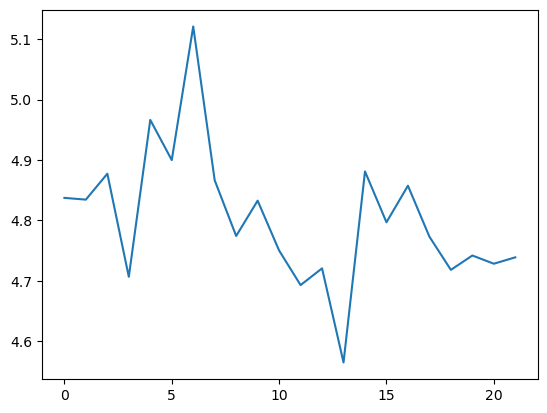

In [45]:
batch_size = 2**10
lr = 5e-3
n_epochs = 2
print_data = False

# print(train_x.shape, train_y.shape)
losses_b, accs_b = mlp_model.fit(generator = get_minibatch, x = train_X_NLP, y = train_Y_NLP, lr = lr, \
                   n_epochs = n_epochs, batch_size = batch_size, print_data = print_data, stop_after_iterations = stop_after_iterations)

mlp_model_params = mlp_model.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses = np.array(losses_b).squeeze()
plt.plot(losses)

In [46]:
Y_pred_NLP_mlp = mlp_model.forward(train_X_NLP)

In [47]:
cm_nlp_mlp = confusion_matrix(test_Y_NLP, Y_pred_NLP_mlp, n_classes = 42)

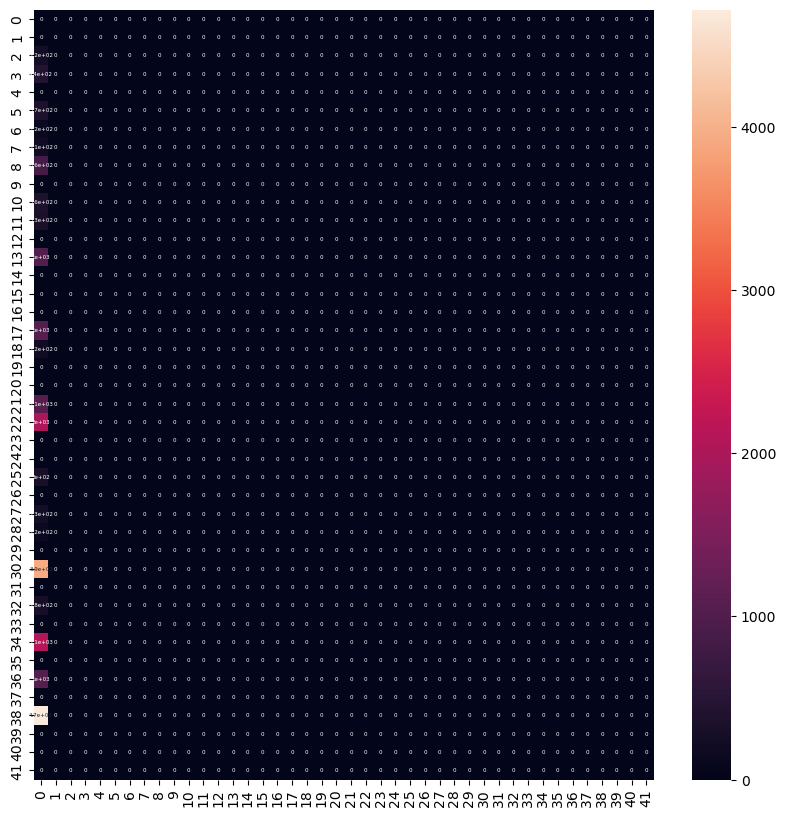

In [48]:
display_cm(cm_nlp_mlp)

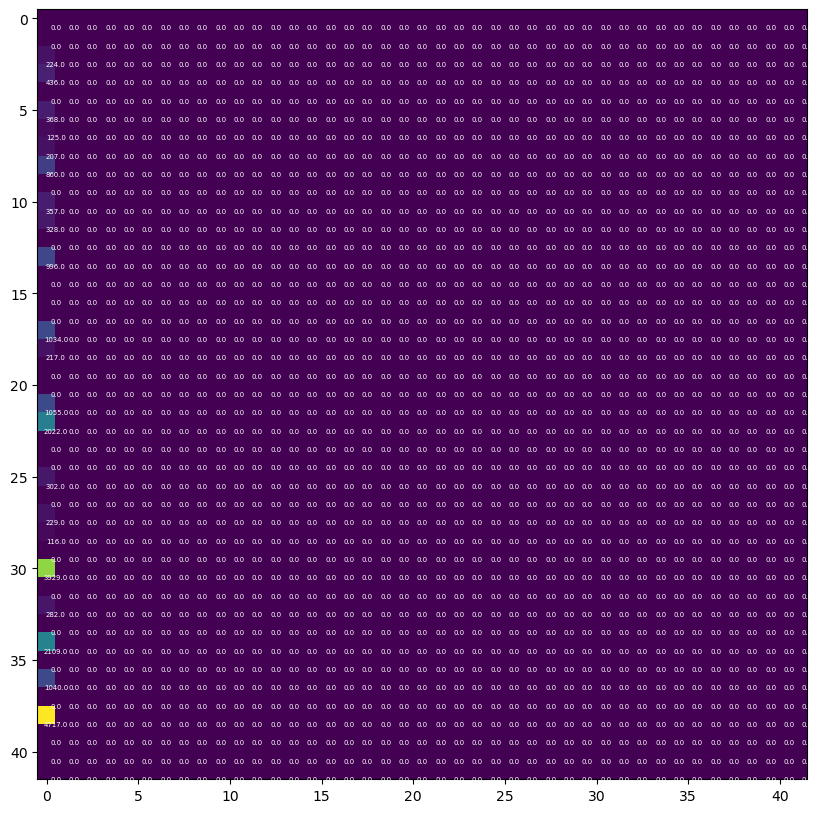

In [114]:
display_cm(cm_nlp_mlp)

In [49]:
np.trace(cm_nlp_mlp)/np.sum(cm_nlp_mlp)

0.0

## Text Classification with Self Attention Block

In [50]:
# X = Xpca[:,:,np.newaxis]
# Y = labels_back

In [51]:
# X = np.random.rand(2, 10, 64) # 1 sample with 10 sequences of dimension 64
# attn_model = SelfAttention(64)
# Y = sa.forward(X)
# print(Y.shape)

# dY = np.random.rand(*Y.shape)
# op = sa.backward(dY)

In [52]:
test_X_NLP.shape

(20953, 100)

In [53]:
test_Y_NLP.shape

(20953, 1)

In [54]:
train_X_NLP.shape

(188574, 100)

In [55]:
train_Y_NLP.shape

(188574, 1)

In [56]:
attn_model = Attention_MLP(dim = 1, T = 100, op_nodes = 42)

dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
0
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
1
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
2
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
3
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
4
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
5
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
6
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
7
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
8
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
9
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
10
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
11
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
12
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
13
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
14
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 100, 1)
15
dloss_by_dY.shape  (4, 100, 1)
self.Y.shape  (4, 1

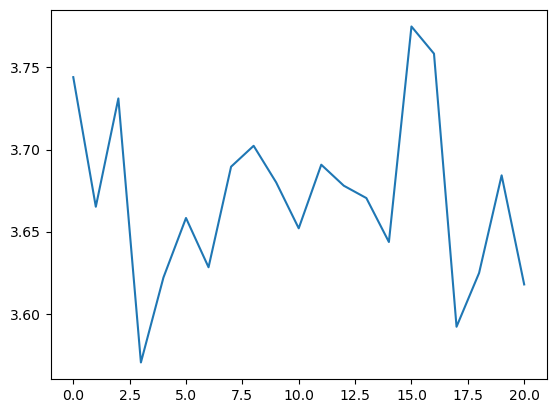

In [57]:
batch_size_attn = 2**2
lr_attn = 5e-3
n_epochs_attn = 1
print_data_attn = False
end_after_first_iteration = False
# print(train_x.shape, train_y.shape)
losses_attn, accs_attn = attn_model.fit(generator = get_minibatch, x = train_X_NLP, y = train_Y_NLP, lr = lr_attn, \
                   n_epochs = n_epochs_attn, batch_size = batch_size_attn, print_data = print_data_attn,\
                                        end_after_first_iteration = end_after_first_iteration,\
                                       stop_after_iterations = stop_after_iterations)

# mlp_model_params = attn_model.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses = np.array(losses_attn).squeeze()
plt.plot(losses)

In [58]:
Y_pred_NLP_attn = np.argmax(attn_model.forward(test_X_NLP[:,:]), axis = 1)

In [59]:
Y_pred_NLP_attn.shape

(20953,)

In [60]:
Y_pred_NLP_attn[:, np.newaxis]

array([[40],
       [40],
       [35],
       ...,
       [35],
       [40],
       [40]], dtype=int64)

In [61]:
cm_attn = confusion_matrix(test_Y_NLP, Y_pred_NLP_attn, n_classes = 42)

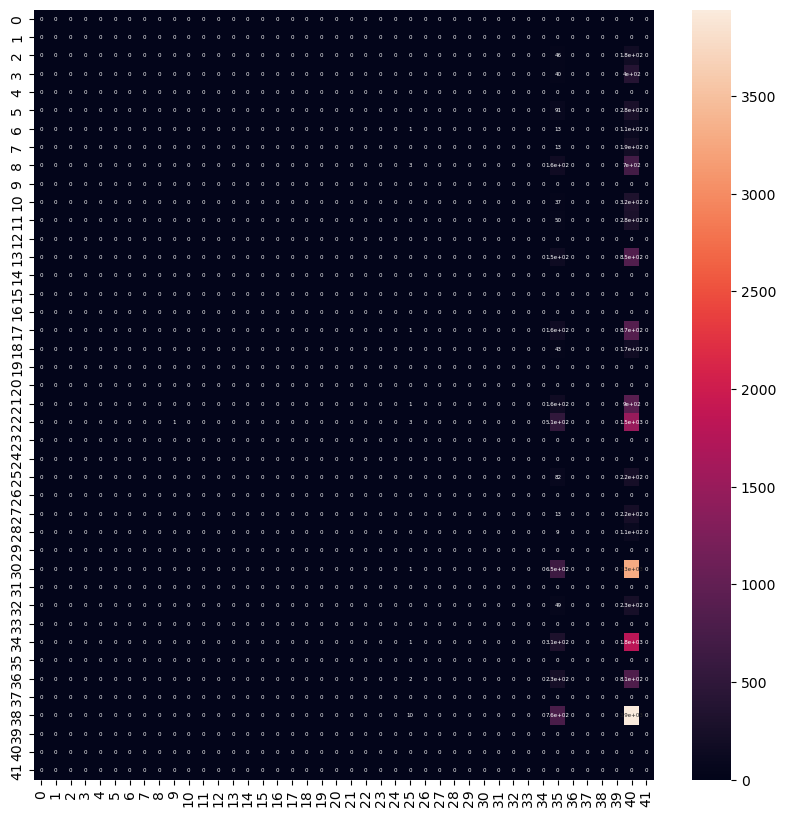

In [62]:
display_cm(cm_attn)

In [63]:
np.trace(cm_attn)/np.sum(cm_attn)

0.0

# Vision Tasks

## Read Vision data

In [76]:
X_VIS = np.load("features.npy")[:,:,0,0]
Y_VIS = np.load("labels.npy")[:,np.newaxis]

In [77]:
Y_VIS.shape

(26176, 1)

In [78]:
maxes = np.max(X_VIS, axis = 0, keepdims = True)
print(maxes.shape)

mins = np.min(X_VIS, axis = 0, keepdims = True)
print(mins.shape)

(1, 512)
(1, 512)


In [79]:
X_VIS1 = (X_VIS - mins)/(maxes-mins)
X_VIS1.shape

(26176, 512)

In [80]:
Y_VIS.shape

(26176, 1)

In [81]:
train_percentage = 90
test_percentage = 10

train_last_index = int(X_VIS.shape[0]*(train_percentage/100))

train_X_im = X_VIS1[:train_last_index]
train_Y_im = Y_VIS[:train_last_index, :]

test_X_im = X_VIS1[train_last_index:]
test_Y_im = Y_VIS[train_last_index:, :]

In [82]:
# shape of X = (n, 512, 1, 1)
# shape of Y = (n, 1)

## MLP

In [83]:
train_X_im_mlp = train_X_im
train_Y_im_mlp = train_Y_im

In [84]:
train_X_im_mlp.shape

(23558, 512)

In [85]:
train_Y_im_mlp.shape

(23558, 1)

In [86]:
mlp_model_vis = Model(ip_nodes = 512, hidden_nodes = [80], op_nodes = 10,\
              intermediate_activations = 'relu',final_activation = 'softmax')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


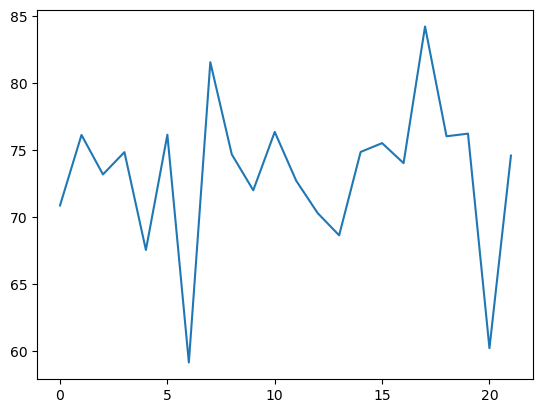

In [87]:
batch_size = 2**5
lr = 5e-3
n_epochs = 2
print_data = False

# print(train_x.shape, train_y.shape)
losses, accs = mlp_model_vis.fit(generator = get_minibatch, x = train_X_im_mlp, y = train_Y_im_mlp, lr = lr, \
                   n_epochs = n_epochs, batch_size = batch_size, print_data = print_data, stop_after_iterations = stop_after_iterations)

mlp_model_params = mlp_model.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses = np.array(losses).squeeze()
plt.plot(losses)

In [88]:
y_pred_vis_mlp = np.argmax(mlp_model_vis.forward(test_X_im), axis = 1, keepdims = True)

In [89]:
cm_vis_mlp = confusion_matrix(test_Y_im, y_pred_vis_mlp, n_classes = 10)

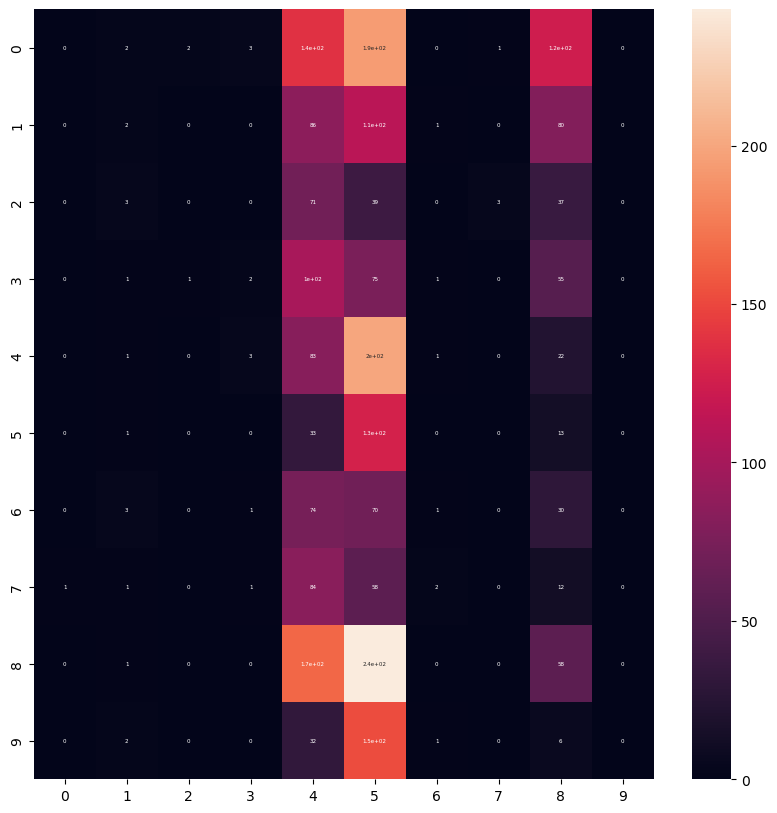

In [90]:
display_cm(cm_vis_mlp)

In [91]:
np.trace(cm_vis_mlp)/np.sum(cm_vis_mlp)

0.10466004583651642

## Attention based MLP

In [92]:
epsilon = 10**-7

In [93]:
train_X_im_attn = train_X_im + epsilon
train_Y_im_attn = train_Y_im

In [94]:
train_X_im_attn.shape

(23558, 512)

In [95]:
train_Y_im_attn.shape

(23558, 1)

In [96]:
attn_model_vis = Attention_MLP(dim = 1, T = 512, op_nodes = 10)

dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
0
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
1
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
2
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
3
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
4
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
5
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
6
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
7
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
8
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
9
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
10
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
11
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
12
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
13
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
14
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 512, 1)
15
dloss_by_dY.shape  (4, 512, 1)
self.Y.shape  (4, 5

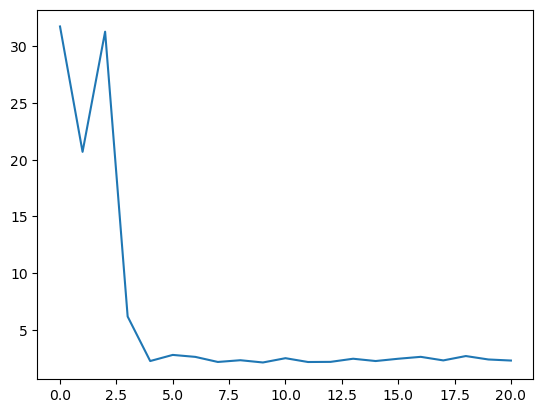

In [97]:
batch_size_attn = 2**2
lr_attn = 5e-4
n_epochs_attn = 1
print_data_attn = False
end_after_first_iteration = False
# print(train_x.shape, train_y.shape)
losses_attn, accs_attn = attn_model_vis.fit(generator = get_minibatch, x = train_X_im_attn, y = train_Y_im_attn, lr = lr_attn, \
                   n_epochs = n_epochs_attn, batch_size = batch_size_attn, print_data = print_data_attn,\
                                        end_after_first_iteration = end_after_first_iteration, stop_after_iterations = stop_after_iterations)

# mlp_model_params = attn_model.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses = np.array(losses_attn).squeeze()
plt.plot(losses)

In [98]:
y_pred_vis_attn = np.argmax(attn_model_vis.forward(test_X_im), axis = 1, keepdims = True)

In [99]:
cm_vis_attn  = confusion_matrix(test_Y_im, y_pred_vis_attn, n_classes = 10)

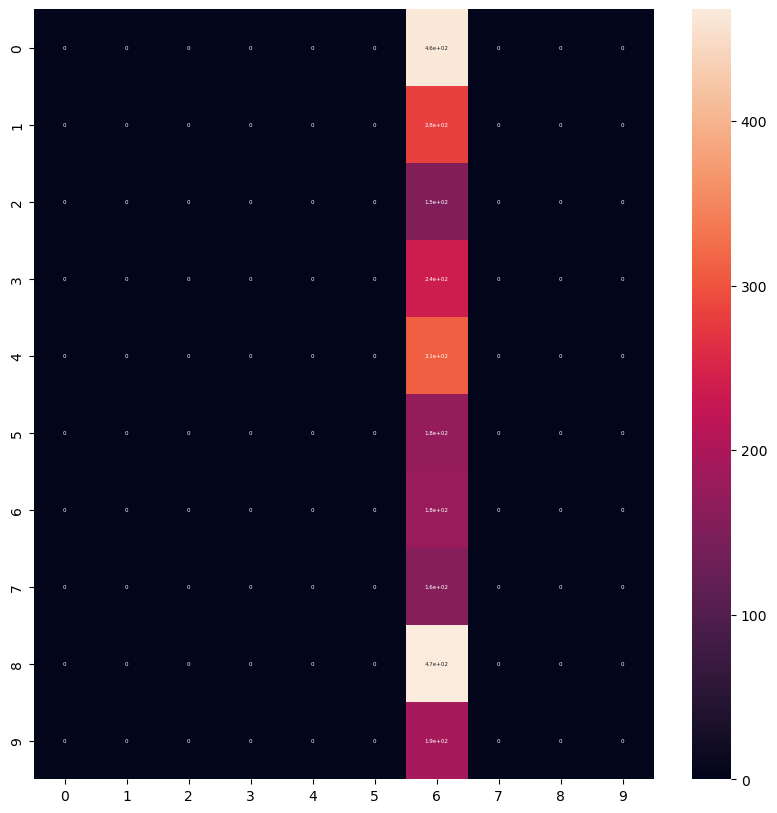

In [100]:
display_cm(cm_vis_attn)

# RANDOM FOREST

In [2]:
# Importing Libraries.

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def accuracy_score(y_true, ypred):
    y_true = y_true.reshape(-1,10)
    ypred = ypred.reshape(-1,10)
    y_true = np.argmax(y_true, axis=1)
    ypred = np.argmax(ypred, axis=1)
    return np.mean(y_true == ypred)

In [4]:
def cf_plot(data, labels, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title("Confusion Matrix for {}".format(classifier_name), fontsize=16)

    cmap = plt.get_cmap('Blues') 
    im = ax.imshow(data, interpolation='nearest', cmap=cmap)

    # Display colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Frequency')  
    cbar.ax.tick_params(labelsize=12)

    # Show all ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    # Set tick labels
    ax.set_xticklabels(labels.astype(int), fontsize=12, rotation=45, ha='right') 
    ax.set_yticklabels(labels.astype(int), fontsize=12)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=12)

    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

    fig.tight_layout()
    plt.show()


In [5]:
def find_metrics(y_predicted, y_ground_truth):
    # Calculate the number of unique classes in the ground truth labels
    class_count = len(np.unique(y_ground_truth))
    # Determine the smallest label in the ground truth set
    min_label = int(np.min(y_ground_truth))
    # Initialize the confusion matrix with zeros
    cm = np.zeros((class_count + min_label, class_count + min_label))
    # Fill the confusion matrix
    for i in range(len(y_ground_truth)):
        cm[int(y_ground_truth[i]), int(y_predicted[i])] += 1

    # Remove rows and columns corresponding to labels not present in the ground truth
    cm = cm[min_label:, min_label:]

    # Calculate class-specific precision, recall, and F1 score
    precision = np.zeros(class_count)
    recall = np.zeros(class_count)
    f1_score = np.zeros(class_count)
    for i in range(class_count):
        precision[i] = cm[i, i] / np.sum(cm[:, i])
        recall[i] = cm[i, i] / np.sum(cm[i, :])
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    # Calculate macro-averaged precision, recall, and F1 score
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Return the confusion matrix and evaluation metrics
    return cm, precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score


In [7]:
class Node:
    def __init__(self, feature=None, threshold=None, data_left = None, data_right = None, gain = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [ ]:
class DecisionTree:
    def __init__(self, d_max, criterion):
        self.d_max = d_max
        self.criterion = criterion
    
    def fit(self, X, y):
        self.class_count = len(np.unique(y))
        self.tree = self.build(X, y, 0)
        
    def build(self, X, y, depth):
        sample_count, feature_count = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.class_count)]
        c_maj = np.argmax(num_samples_per_class)
        if depth == self.d_max or self.class_count == 1:
            return {'leaf': True, 'class': c_maj}
        if sample_count == 0:
            return {'leaf': True, 'class': c_maj}
        if np.all(y == y[0]):
            return {'leaf': True, 'class': y[0]}
        indices = np.arange(feature_count)
        np.random.shuffle(indices)
        indices = indices[:int(np.sqrt(feature_count))]

        if self.criterion == 'Gini':
            best_gini = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    gini_left = 1 - sum((np.sum(y[l_ind] == c) / num_samples_left) ** 2 for c in range(self.class_count))
                    gini_right = 1 - sum((np.sum(y[r_ind] == c) / num_samples_right) ** 2 for c in range(self.class_count))
                    weighted_gini = (num_samples_left / sample_count) * gini_left + (num_samples_right / sample_count) * gini_right
                    if weighted_gini < best_gini:
                        best_gini = weighted_gini
                        best_index = index
                        best_threshold = threshold
                        
        elif self.criterion == 'Entropy':
            best_entropy = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    el = -sum((np.sum(y[l_ind] == c) / num_samples_left) * np.log2((np.sum(y[l_ind] == c) / num_samples_left) + 1e-10) for c in range(self.class_count))
                    er = -sum((np.sum(y[r_ind] == c) / num_samples_right) * np.log2((np.sum(y[r_ind] == c) / num_samples_right) + 1e-10) for c in range(self.class_count))
                    weighted_entropy = (num_samples_left / sample_count) * el + (num_samples_right / sample_count) * er
                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_index = index
                        best_threshold = threshold
        l_ind = X[:, best_index] <= best_threshold
        r_ind = X[:, best_index] > best_threshold
        l_tree = self.build(X[l_ind], y[l_ind], depth + 1)
        r_tree = self.build(X[r_ind], y[r_ind], depth + 1)
        return {'leaf': False,
                'index': best_index,
                'threshold': best_threshold,
                'l_tree': l_tree,
                'r_tree': r_tree}

    def predict(self, X):
        return np.array([self.traverse(x, self.tree) for x in X])
    def traverse(self, x, node):
        if node['leaf']:
            return node['class']
        if x[node['index']] <= node['threshold']:
            return self.traverse(x, node['l_tree'])
        else:
            return self.traverse(x, node['r_tree'])

In [9]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees = 25, min_samples_split = 2, max_depth = 5 , max_features = 100):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split = self.min_samples_split,
                    max_depth = self.max_depth,
                    max_features = self.max_features
                )
                _X, _y = self._sample(X, y)
                clf.fit(_X, _y)
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue
    
    def predict(self, X):
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        y = np.swapaxes(y, 0, 1)

        predictions = []
        for preds in y:
            label_counts = {}
            for label in preds:
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1
            max_count = 0
            max_label = None
            for label, count in label_counts.items():
                if count > max_count:
                    max_count = count
                    max_label = label
            predictions.append(max_label)
        return predictions

In [10]:
data=np.load("C:/Users/nilad/Downloads/pca.npz")
print("Keys in the loaded data:", list(data.keys()))
x = np.array(data[list(data.keys())[0]])
y = (data[list(data.keys())[1]])

z = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
num_classes = len(z)
# one_hot_y = np.zeros((len(y), num_classes))
for i, label in enumerate(y):
    label_index = z.index(label)
    y[i] = label_index+1
# y=np.array(one_hot_y)
print(x.shape,y.shape)
data = np.column_stack((x, y))
np.random.shuffle(data)
shuffled_x = data[:, :-1] 
shuffled_y = data[:, -1]  
train_ratio = 0.8
num_train_samples = int(train_ratio * len(shuffled_x))

xtrain = shuffled_x[:num_train_samples]
xtest = shuffled_x[num_train_samples:]
ytrain = shuffled_y[:num_train_samples]
ytest = shuffled_y[num_train_samples:]

xtrain = xtrain.astype(float)
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
xtest = xtest.astype(float)
print(xtrain.shape,ytrain.shape)
xtrain=xtrain/255
xtest/=255


Keys in the loaded data: ['data', 'labels']
(24209, 512) (24209,)
(19367, 512) (19367,)


Applying Random Forest with varying number of Features and Trees on Animal Dataset.



C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 5 , Number of features : 5
Accuracy : 0.17
Class wise Precision Values : [0.18987342 0.16129032 0.         0.         0.13580247 0.06666667
 0.0952381  0.         0.22647059 0.        ]
Class wise Recall Values : [0.5        0.05154639 0.         0.         0.08029197 0.01785714
 0.02739726 0.         0.39086294 0.        ]
Class wise F1 scores : [0.27522936 0.078125          nan        nan 0.10091743 0.02816901
 0.04255319        nan 0.2867784         nan]
Overall Precision Value : 0.08753415595780226
Overall Recall Value : 0.10679557098490491
Overall F1 score : nan


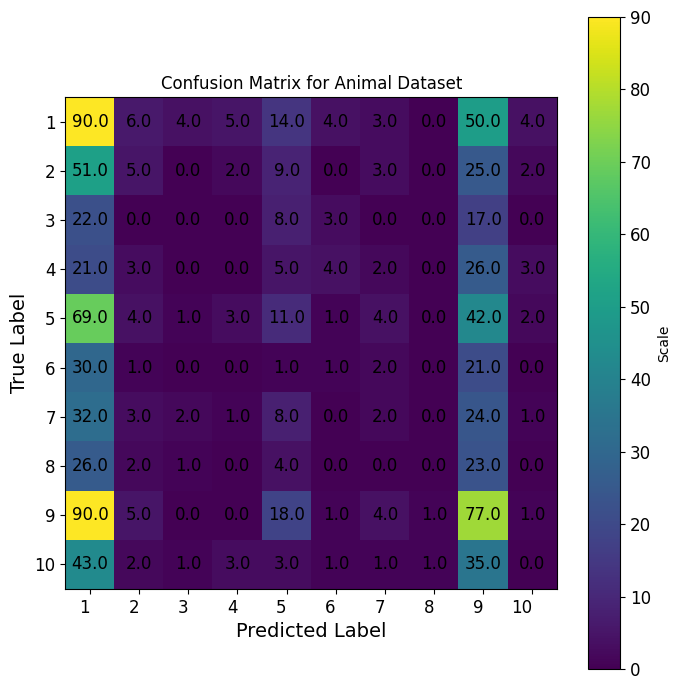

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 5 , Number of features : 15
Accuracy : 0.18
Class wise Precision Values : [0.16333333 0.15555556 0.16666667 0.25       0.16       0.
 0.0877193  0.06666667 0.2763466  0.13888889]
Class wise Recall Values : [0.27222222 0.07216495 0.02       0.03125    0.08759124 0.
 0.06849315 0.05357143 0.59898477 0.05555556]
Class wise F1 scores : [0.20416667 0.09859155 0.03571429 0.05555556 0.11320755        nan
 0.07692308 0.05940594 0.37820513 0.07936508]
Overall Precision Value : 0.14651770135721817
Overall Recall Value : 0.12598333179372626
Overall F1 score : nan


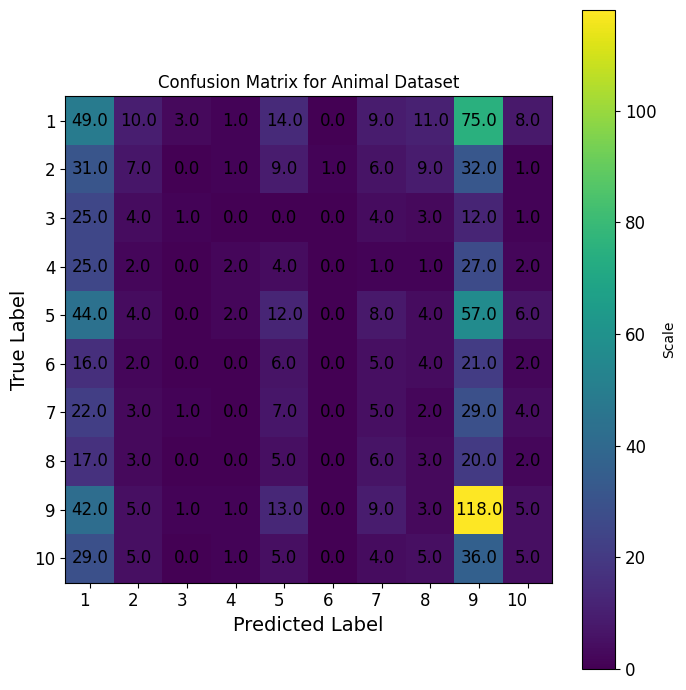

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 5 , Number of features : 25
Accuracy : 0.17
Class wise Precision Values : [0.19318182 0.12280702 0.         0.04347826 0.19047619 0.
 0.14285714 0.03571429 0.26107226 0.15789474]
Class wise Recall Values : [0.37777778 0.07216495 0.         0.015625   0.05839416 0.
 0.02739726 0.01785714 0.56852792 0.06666667]
Class wise F1 scores : [0.2556391  0.09090909        nan 0.02298851 0.08938547        nan
 0.04597701 0.02380952 0.35782748 0.09375   ]
Overall Precision Value : 0.11474817135572284
Overall Recall Value : 0.12044108753948357
Overall F1 score : nan


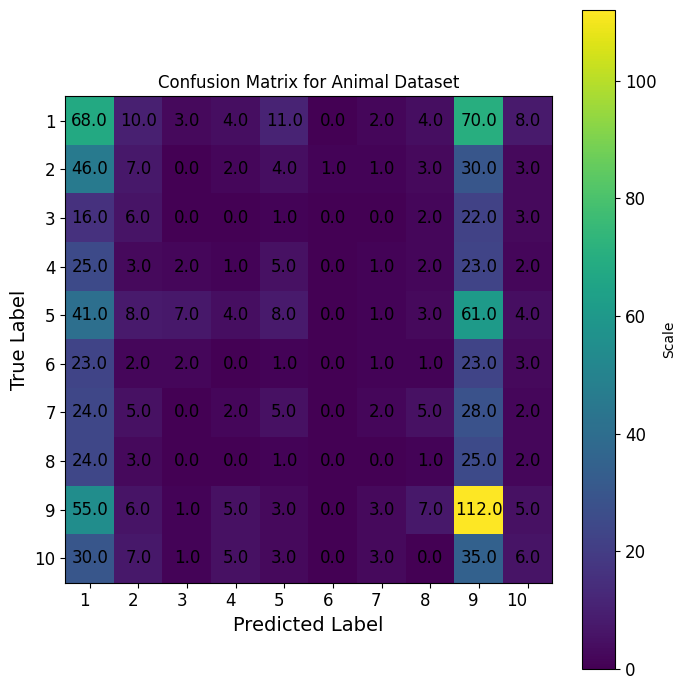

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 5 , Number of features : 35
Accuracy : 0.17
Class wise Precision Values : [0.25242718 0.06896552 0.         0.11111111 0.2        0.09090909
 0.13043478 0.08333333 0.26959847 0.        ]
Class wise Recall Values : [0.43333333 0.02061856 0.         0.015625   0.10218978 0.01785714
 0.04109589 0.01785714 0.71573604 0.        ]
Class wise F1 scores : [0.3190184  0.03174603        nan 0.02739726 0.1352657  0.02985075
 0.0625     0.02941176 0.39166667        nan]
Overall Precision Value : 0.12067794900329185
Overall Recall Value : 0.13643128877906435
Overall F1 score : nan


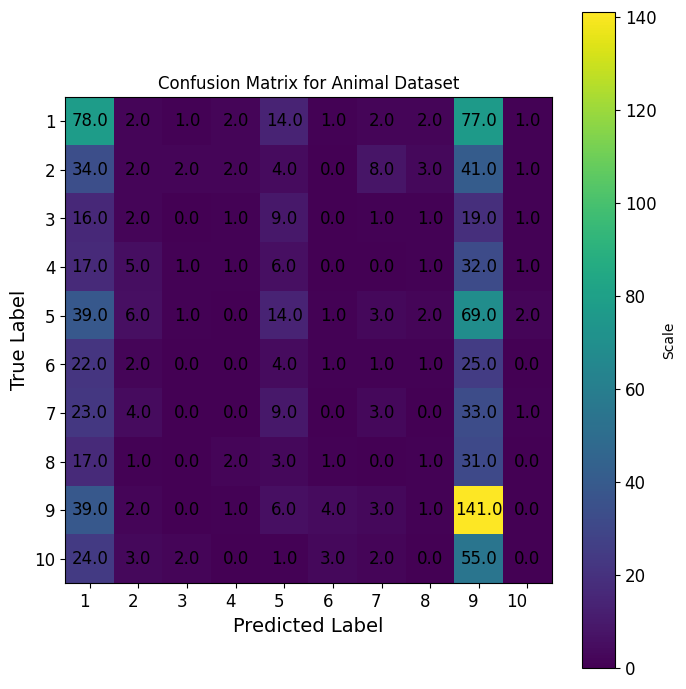

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 10 , Number of features : 5
Accuracy : 0.15
Class wise Precision Values : [0.19222904 0.26315789 0.         0.         0.1875     0.5
 0.         0.         0.25882353 0.        ]
Class wise Recall Values : [0.52222222 0.05154639 0.         0.         0.06569343 0.01785714
 0.         0.         0.55837563 0.        ]
Class wise F1 scores : [0.28101644 0.0862069         nan        nan 0.0972973  0.03448276
        nan        nan 0.35369775        nan]
Overall Precision Value : 0.14017104630034125
Overall Recall Value : 0.12156948220066432
Overall F1 score : nan


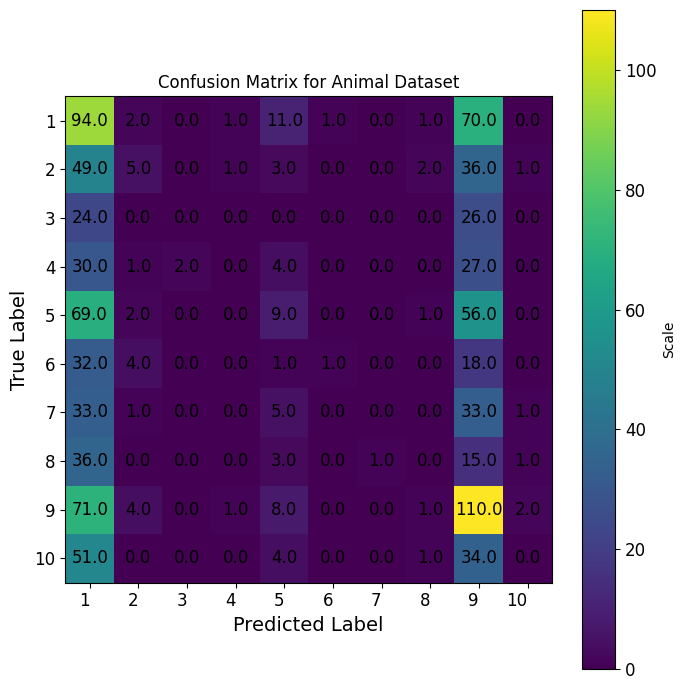

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 10 , Number of features : 15
Accuracy : 0.12
Class wise Precision Values : [0.18881119 0.29166667        nan 0.         0.22727273 0.
 0.11111111 0.         0.24958403 0.125     ]
Class wise Recall Values : [0.3        0.07216495 0.         0.         0.10948905 0.
 0.01369863 0.         0.76142132 0.01111111]
Class wise F1 scores : [0.23175966 0.11570248        nan        nan 0.14778325        nan
 0.02439024        nan 0.37593985 0.02040816]
Overall Precision Value : nan
Overall Recall Value : 0.12678850605935504
Overall F1 score : nan


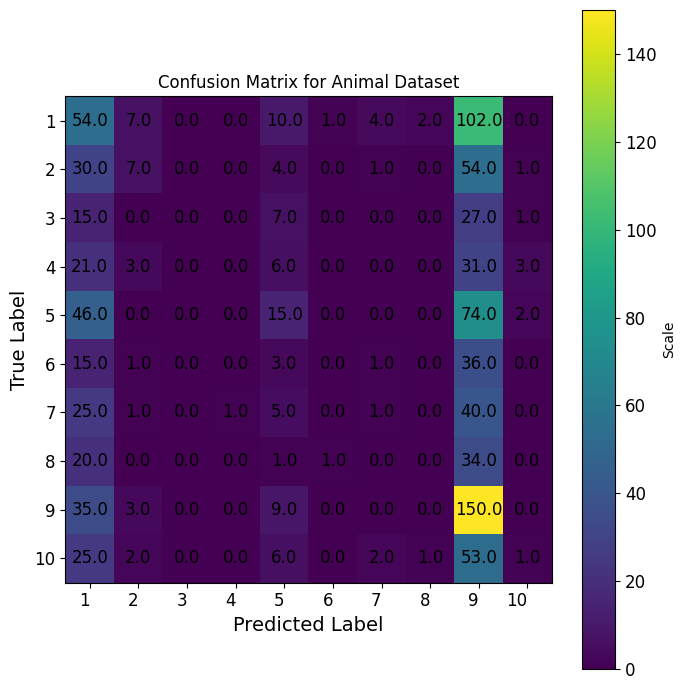

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 10 , Number of features : 25
Accuracy : 0.18
Class wise Precision Values : [0.22113022 0.19565217 0.         0.         0.16346154 0.
 0.         0.         0.33333333 0.4       ]
Class wise Recall Values : [0.5        0.09278351 0.         0.         0.24817518 0.
 0.         0.         0.5177665  0.02222222]
Class wise F1 scores : [0.30664395 0.12587413        nan        nan 0.19710145        nan
        nan        nan 0.4055666  0.04210526]
Overall Precision Value : 0.13135772668381365
Overall Recall Value : 0.13809474073205422
Overall F1 score : nan


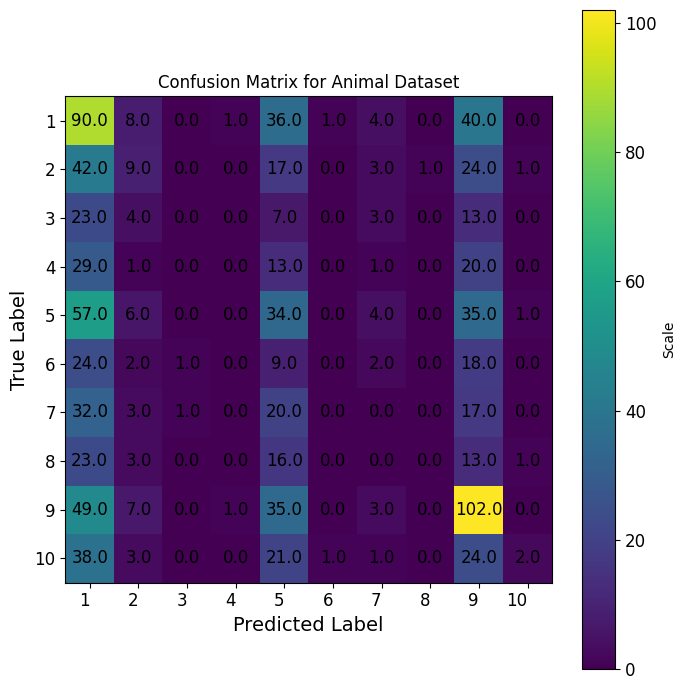

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 10 , Number of features : 35
Accuracy : 0.14
Class wise Precision Values : [0.17391304 0.22222222 0.         0.         0.08333333 0.
 0.2        0.14285714 0.27126437 0.        ]
Class wise Recall Values : [0.48888889 0.04123711 0.         0.         0.00729927 0.
 0.01369863 0.01785714 0.59898477 0.        ]
Class wise F1 scores : [0.25655977 0.06956522        nan        nan 0.01342282        nan
 0.02564103 0.03174603 0.37341772        nan]
Overall Precision Value : 0.10935901097070513
Overall Recall Value : 0.11679658169316767
Overall F1 score : nan


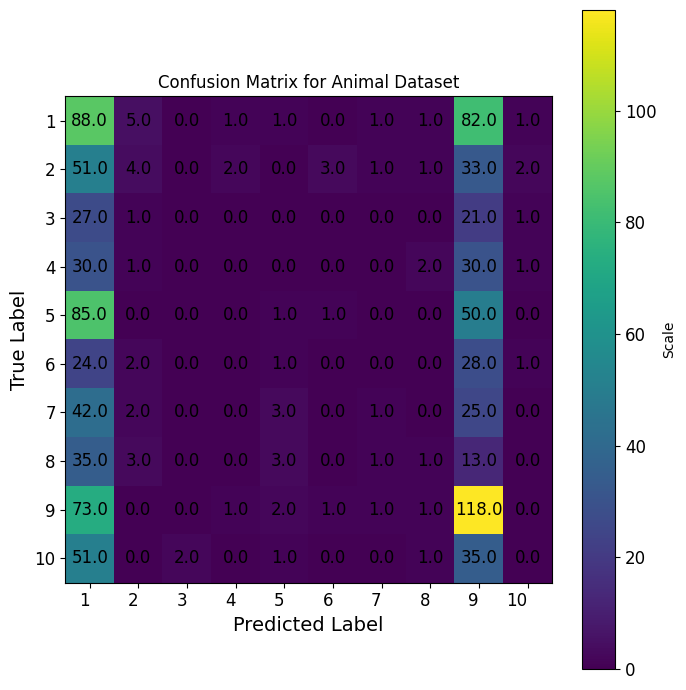

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 15 , Number of features : 5
Accuracy : 0.15
Class wise Precision Values : [0.20967742 0.33333333        nan 1.         0.07692308        nan
 0.         0.         0.24015009 0.        ]
Class wise Recall Values : [0.50555556 0.01030928 0.         0.015625   0.01459854 0.
 0.         0.         0.64974619 0.        ]
Class wise F1 scores : [0.29641694 0.02              nan 0.03076923 0.02453988        nan
        nan        nan 0.35068493        nan]
Overall Precision Value : nan
Overall Recall Value : 0.11958345669454573
Overall F1 score : nan


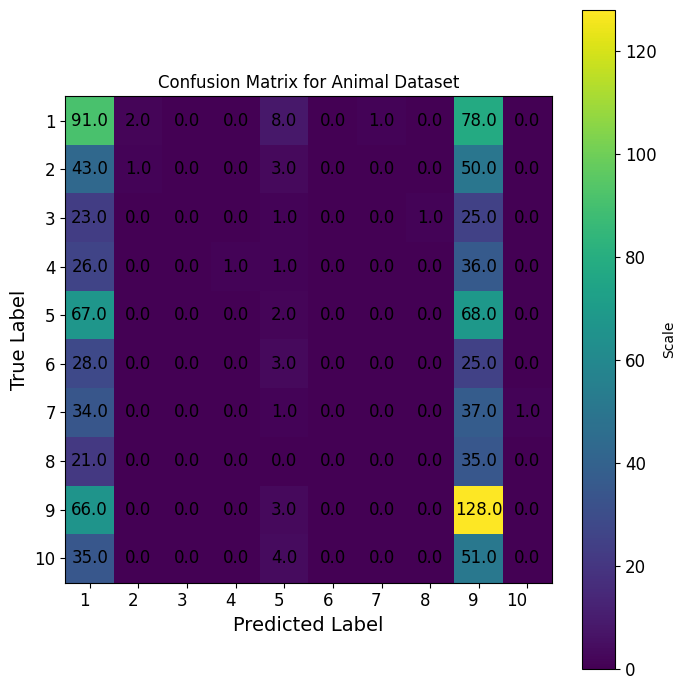

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 15 , Number of features : 15
Accuracy : 0.17
Class wise Precision Values : [0.17382413 0.11764706        nan 0.         0.25925926        nan
 0.         0.11111111 0.23348018 0.        ]
Class wise Recall Values : [0.47222222 0.02061856 0.         0.         0.05109489 0.
 0.         0.01785714 0.53807107 0.        ]
Class wise F1 scores : [0.25411061 0.03508772        nan        nan 0.08536585        nan
        nan 0.03076923 0.32565284        nan]
Overall Precision Value : nan
Overall Recall Value : 0.10998638782811927
Overall F1 score : nan


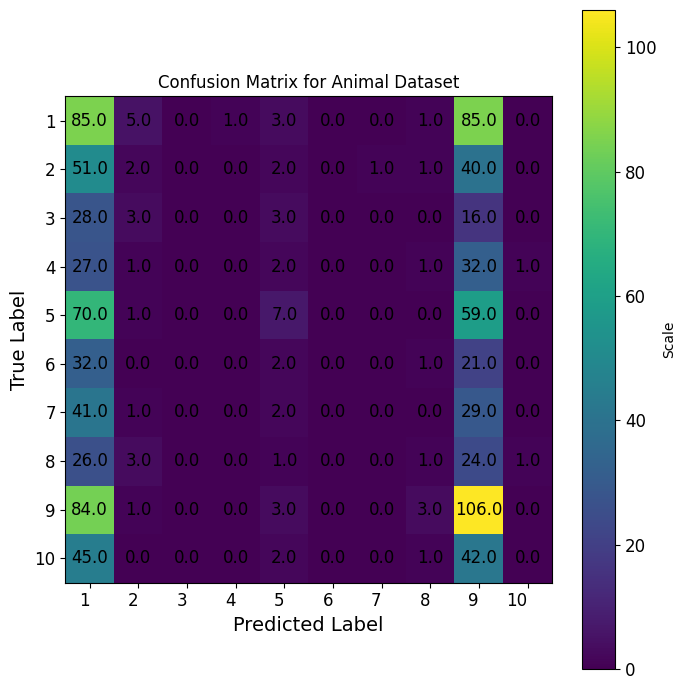

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


Number of trees: 15 , Number of features : 25
Accuracy : 0.21
Class wise Precision Values : [0.20887728 0.07142857        nan 0.         0.18918919        nan
 0.125      0.         0.26848249 0.25      ]
Class wise Recall Values : [0.44444444 0.01030928 0.         0.         0.10218978 0.
 0.01369863 0.         0.70050761 0.01111111]
Class wise F1 scores : [0.28419183 0.01801802        nan        nan 0.13270142        nan
 0.02469136        nan 0.38818565 0.0212766 ]
Overall Precision Value : nan
Overall Recall Value : 0.12822608592781531
Overall F1 score : nan


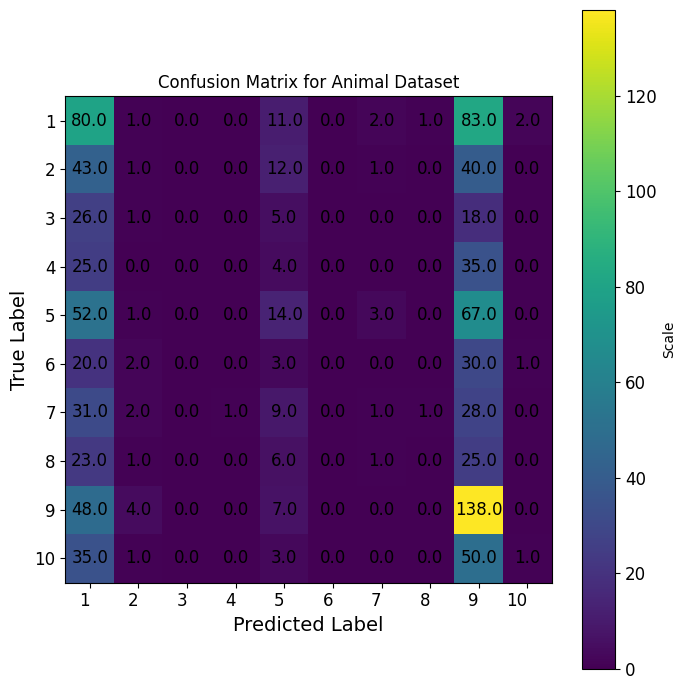

C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_21956\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])


Number of trees: 15 , Number of features : 35
Accuracy : 0.16
Class wise Precision Values : [0.17948718 0.22222222 0.33333333 0.         0.37037037        nan
 0.07692308 0.5        0.24137931 0.        ]
Class wise Recall Values : [0.27222222 0.02061856 0.02       0.         0.0729927  0.
 0.01369863 0.01785714 0.81725888 0.        ]
Class wise F1 scores : [0.21633554 0.03773585 0.03773585        nan 0.12195122        nan
 0.02325581 0.03448276 0.37268519        nan]
Overall Precision Value : nan
Overall Recall Value : 0.12346481358960401
Overall F1 score : nan


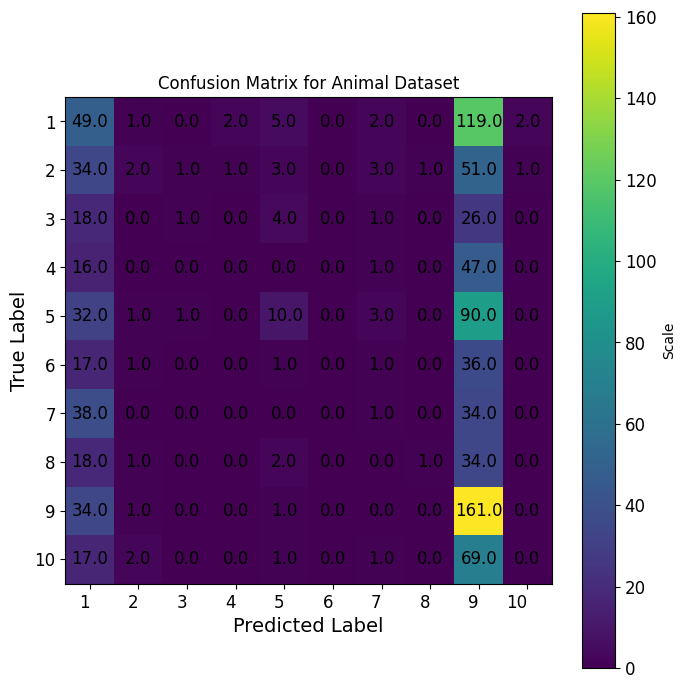

In [11]:
# List of values to try for the number of trees and number of features
n_trees_values = [ 5, 10, 15]
n_features_values = [5, 15 , 25 , 35]

print("Applying Random Forest with varying number of Features and Trees on Animal Dataset.\n")

# Loop through the different values
for n_trees in n_trees_values:
    for n_features in n_features_values:
        rf = RandomForest(num_trees = n_trees, max_features = n_features)
        
        # Fit the classifier on the training data
        rf.fit(xtrain[:1000], ytrain[:1000])
        
        # Make predictions on the test data
        y_pred = rf.predict(xtest[:1000])
        
        # Calculate accuracy and print the results
        accuracy = accuracy_score(np.array(ytest[:1000]), np.array(y_pred))
        confusion_matrix, class_precision, class_recall, class_f1, overall_precision, overall_recall, overall_f1 =  find_metrics(np.array(ypred), np.array(ytest[:4000]))
        print(f"Number of trees: {n_trees} , Number of features : {n_features}")
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision  : {class_precision}")
        print(f"Class wise Recall  : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision  : {overall_precision}")
        print(f"Overall Recall  : {overall_recall}")
        print(f"Overall F1 score : {overall_f1}")
        cf_plot(confusion_matrix , np.unique(ytest[0:4000]), "Animal Dataset")

# DECISION TREE

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def accuracy_score(y_true, ypred):
    y_true = y_true.reshape(-1,10)
    ypred = ypred.reshape(-1,10)
    y_true = np.argmax(y_true, axis=1)
    ypred = np.argmax(ypred, axis=1)
    return np.mean(y_true == ypred)

In [24]:
def cf_plot(data, labels, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title("Confusion Matrix for {}".format(classifier_name), fontsize=16)

    cmap = plt.get_cmap('Blues') 
    im = ax.imshow(data, interpolation='nearest', cmap=cmap)

    # Display colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Frequency')  
    cbar.ax.tick_params(labelsize=12)

    # Show all ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    # Set tick labels
    ax.set_xticklabels(labels.astype(int), fontsize=12, rotation=45, ha='right') 
    ax.set_yticklabels(labels.astype(int), fontsize=12)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=12)

    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

    fig.tight_layout()
    plt.show()


In [23]:
def find_metrics(y_predicted, y_ground_truth):
    # Calculate the number of unique classes in the ground truth labels
    class_count = len(np.unique(y_ground_truth))
    # Determine the smallest label in the ground truth set
    min_label = int(np.min(y_ground_truth))
    # Initialize the confusion matrix with zeros
    cm = np.zeros((class_count + min_label, class_count + min_label))
    # Fill the confusion matrix
    for i in range(len(y_ground_truth)):
        cm[int(y_ground_truth[i]), int(y_predicted[i])] += 1

    # Remove rows and columns corresponding to labels not present in the ground truth
    cm = cm[min_label:, min_label:]

    # Calculate class-specific precision, recall, and F1 score
    precision = np.zeros(class_count)
    recall = np.zeros(class_count)
    f1_score = np.zeros(class_count)
    for i in range(class_count):
        precision[i] = cm[i, i] / np.sum(cm[:, i])
        recall[i] = cm[i, i] / np.sum(cm[i, :])
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    # Calculate macro-averaged precision, recall, and F1 score
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Return the confusion matrix and evaluation metrics
    return cm, precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score


In [22]:
class DecisionTree:
    def __init__(self, d_max, criterion):
        self.d_max = d_max
        self.criterion = criterion
    
    def fit(self, X, y):
        self.class_count = len(np.unique(y))
        self.tree = self.build(X, y, 0)
        
    def build(self, X, y, depth):
        sample_count, feature_count = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.class_count)]
        c_maj = np.argmax(num_samples_per_class)
        if depth == self.d_max or self.class_count == 1:
            return {'leaf': True, 'class': c_maj}
        if sample_count == 0:
            return {'leaf': True, 'class': c_maj}
        if np.all(y == y[0]):
            return {'leaf': True, 'class': y[0]}
        indices = np.arange(feature_count)
        np.random.shuffle(indices)
        indices = indices[:int(np.sqrt(feature_count))]

        if self.criterion == 'Gini':
            best_gini = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    gini_left = 1 - sum((np.sum(y[l_ind] == c) / num_samples_left) ** 2 for c in range(self.class_count))
                    gini_right = 1 - sum((np.sum(y[r_ind] == c) / num_samples_right) ** 2 for c in range(self.class_count))
                    weighted_gini = (num_samples_left / sample_count) * gini_left + (num_samples_right / sample_count) * gini_right
                    if weighted_gini < best_gini:
                        best_gini = weighted_gini
                        best_index = index
                        best_threshold = threshold
                        
        elif self.criterion == 'Entropy':
            best_entropy = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    el = -sum((np.sum(y[l_ind] == c) / num_samples_left) * np.log2((np.sum(y[l_ind] == c) / num_samples_left) + 1e-10) for c in range(self.class_count))
                    er = -sum((np.sum(y[r_ind] == c) / num_samples_right) * np.log2((np.sum(y[r_ind] == c) / num_samples_right) + 1e-10) for c in range(self.class_count))
                    weighted_entropy = (num_samples_left / sample_count) * el + (num_samples_right / sample_count) * er
                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_index = index
                        best_threshold = threshold
        l_ind = X[:, best_index] <= best_threshold
        r_ind = X[:, best_index] > best_threshold
        l_tree = self.build(X[l_ind], y[l_ind], depth + 1)
        r_tree = self.build(X[r_ind], y[r_ind], depth + 1)
        return {'leaf': False,
                'index': best_index,
                'threshold': best_threshold,
                'l_tree': l_tree,
                'r_tree': r_tree}

    def predict(self, X):
        return np.array([self.traverse(x, self.tree) for x in X])
    def traverse(self, x, node):
        if node['leaf']:
            return node['class']
        if x[node['index']] <= node['threshold']:
            return self.traverse(x, node['l_tree'])
        else:
            return self.traverse(x, node['r_tree'])

In [9]:
data=np.load("C:/Users/nilad/Downloads/pca.npz")
print("Keys in the loaded data:", list(data.keys()))
x = np.array(data[list(data.keys())[0]])
y = (data[list(data.keys())[1]])
z = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
class_count = len(z)
# one_hot_y = np.zeros((len(y), class_count))
for i, label in enumerate(y):
    label_index = z.index(label)
    y[i] = label_index+1
# y=np.array(one_hot_y)
print(x.shape,y.shape)
data = np.column_stack((x, y))

# Shuffle the rows of the combined data
np.random.shuffle(data)

# Split the shuffled data into x and y again
shuffled_x = data[:, :-1]  # All columns except the last one are features
shuffled_y = data[:, -1]  
train_ratio = 0.8
num_train_samples = int(train_ratio * len(shuffled_x))

# Extract training and testing sets
xtrain = shuffled_x[:num_train_samples]
xtest = shuffled_x[num_train_samples:]
ytrain = shuffled_y[:num_train_samples]
ytest = shuffled_y[num_train_samples:]

xtrain = xtrain.astype(float)/255.0
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
xtest = xtest.astype(float)/255.0
print(xtrain.shape,ytrain.shape)


Keys in the loaded data: ['data', 'labels']
(24209, 512) (24209,)
(19367, 512) (19367,)


Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on Animal Dataset.

Max depth=8, Impurity criterion=gini
Accuracy : 0.215
Class wise Precision  : [0.22866175 0.25742574 0.02439024 0.09210526 0.14613181 0.16666667
 0.17       0.03703704 0.31935484        nan]
Class wise Recall  : [0.53913043 0.11428571 0.00625    0.02916667 0.09922179 0.00921659
 0.05685619 0.01167315 0.53877551 0.        ]
Class wise F1 scores : [0.32112468 0.15829528 0.00995025 0.0443038  0.11819235 0.01746725
 0.08521303 0.01775148 0.40101266        nan]
Overall Precision  : nan
Overall Recall  : 0.14045760447260336
Overall F1 score : nan


C:\Users\nilad\AppData\Local\Temp\ipykernel_9352\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])


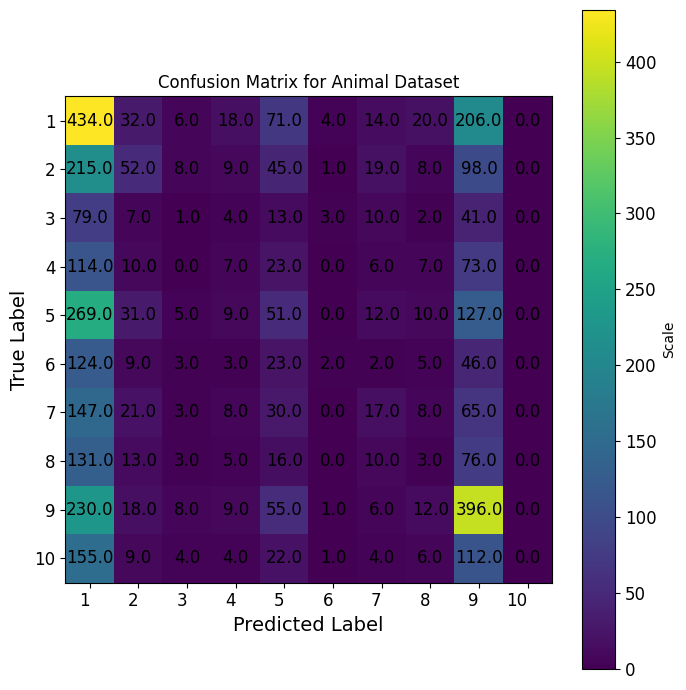

Max depth=8, Impurity criterion=entropy
Accuracy : 0.1875
Class wise Precision  : [0.21843208 0.20089286 0.04545455 0.12149533 0.18579235 0.15384615
 0.11875    0.07692308 0.27702219        nan]
Class wise Recall  : [0.4539801  0.0989011  0.00625    0.05416667 0.13203883 0.01843318
 0.06354515 0.0077821  0.52653061 0.        ]
Class wise F1 scores : [0.29494949 0.13254786 0.01098901 0.07492795 0.15437003 0.03292181
 0.08278867 0.01413428 0.3630394         nan]
Overall Precision  : nan
Overall Recall  : 0.13616277436590973
Overall F1 score : nan


C:\Users\nilad\AppData\Local\Temp\ipykernel_9352\101377052.py:27: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])


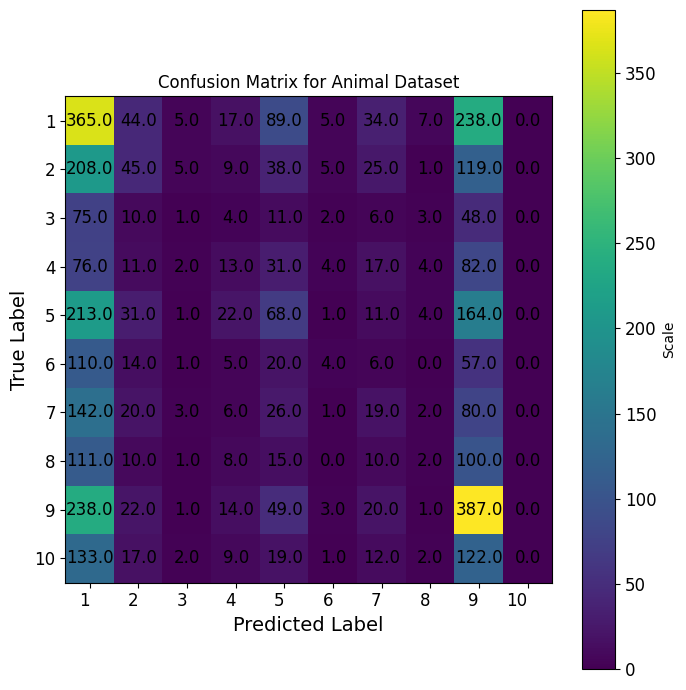

Max depth=10, Impurity criterion=gini
Accuracy : 0.22
Class wise Precision  : [0.22611684 0.17004049 0.08888889 0.12931034 0.13779528 0.
 0.12903226 0.12621359 0.32533333 0.        ]
Class wise Recall  : [0.40971357 0.09251101 0.025      0.0625     0.20428016 0.
 0.04026846 0.05078125 0.4986376  0.        ]
Class wise F1 scores : [0.29140833 0.11982882 0.03902439 0.08426966 0.1645768         nan
 0.06138107 0.0724234  0.39376009        nan]
Overall Precision  : 0.13327310172558174
Overall Recall  : 0.13836920515106937
Overall F1 score : nan


C:\Users\nilad\AppData\Local\Temp\ipykernel_9352\101377052.py:29: RuntimeWarning: invalid value encountered in scalar divide
  class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])


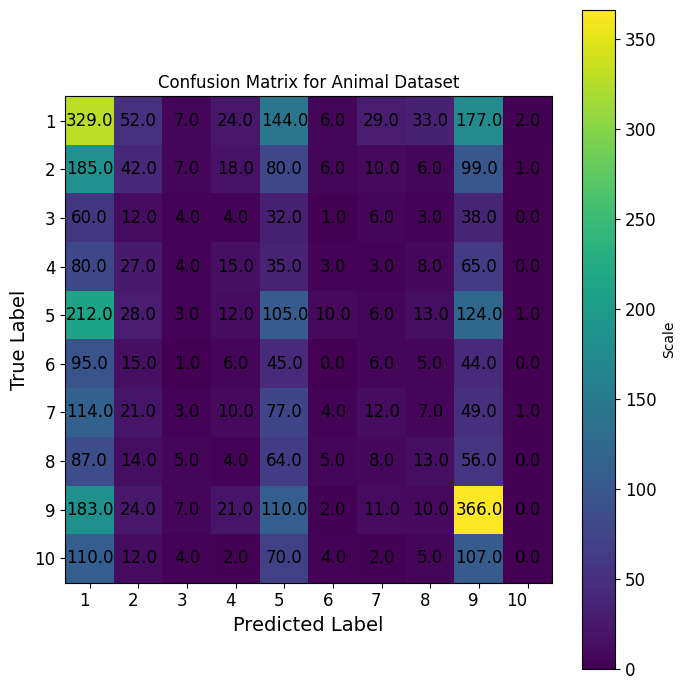

Max depth=10, Impurity criterion=entropy
Accuracy : 0.2275
Class wise Precision  : [0.22914467 0.16971279 0.16071429 0.05747126 0.17748092 0.10169492
 0.13888889 0.192      0.3062453  0.18181818]
Class wise Recall  : [0.27023661 0.14348786 0.05625    0.04166667 0.18164062 0.08333333
 0.11744966 0.09338521 0.55525239 0.0126183 ]
Class wise F1 scores : [0.248      0.15550239 0.08333333 0.04830918 0.17953668 0.09160305
 0.12727273 0.12565445 0.39476237 0.02359882]
Overall Precision  : 0.17151712103942215
Overall Recall  : 0.1555320658838134
Overall F1 score : 0.14775730016214264


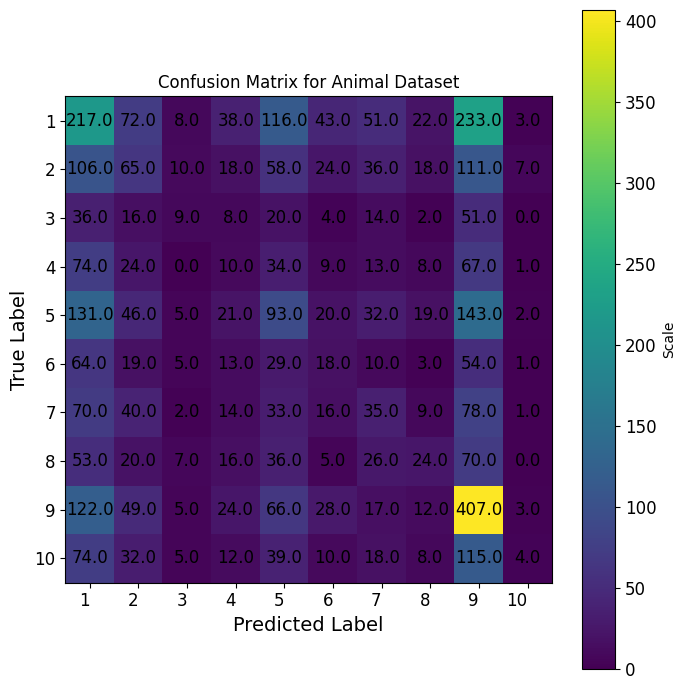

Max depth=12, Impurity criterion=gini
Accuracy : 0.205
Class wise Precision  : [0.21078431 0.20359281 0.06944444 0.08609272 0.15865385 0.05970149
 0.12258065 0.11570248 0.26382979 0.13333333]
Class wise Recall  : [0.215      0.15044248 0.03125    0.05439331 0.25680934 0.01843318
 0.06354515 0.0546875  0.50681199 0.0126183 ]
Class wise F1 scores : [0.21287129 0.17302799 0.04310345 0.06666667 0.1961367  0.02816901
 0.08370044 0.07427056 0.34701493 0.02305476]
Overall Precision  : 0.1423715871531649
Overall Recall  : 0.1363991237692798
Overall F1 score : 0.12480157852891013


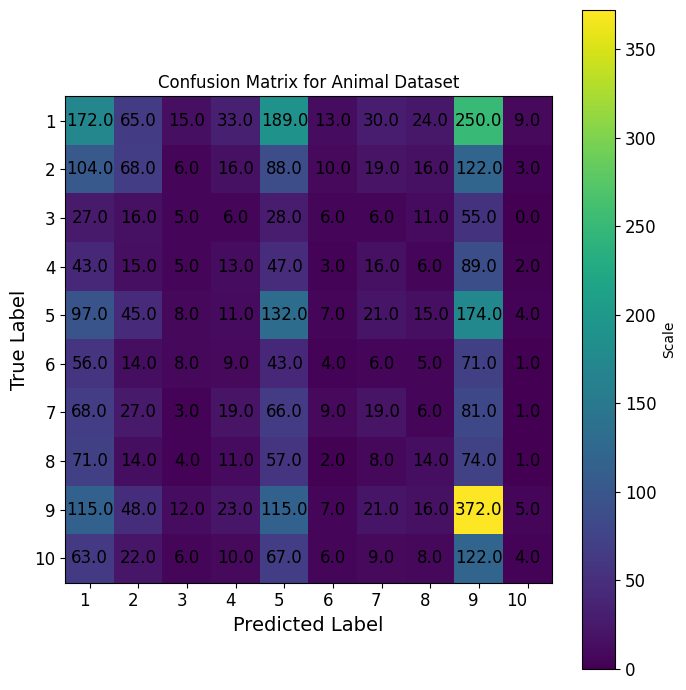

Max depth=12, Impurity criterion=entropy
Accuracy : 0.165
Class wise Precision  : [0.22819383 0.14659686 0.03100775 0.11917098 0.15695067 0.03960396
 0.09688581 0.15079365 0.31526649 0.04761905]
Class wise Recall  : [0.32496863 0.1247216  0.02515723 0.09663866 0.13671875 0.01843318
 0.09459459 0.07392996 0.47808219 0.00949367]
Class wise F1 scores : [0.26811594 0.13477738 0.02777778 0.10672854 0.14613779 0.02515723
 0.0957265  0.09921671 0.37996734 0.01583113]
Overall Precision  : 0.13320890582332653
Overall Recall  : 0.13827384721759434
Overall F1 score : 0.12994363330303063


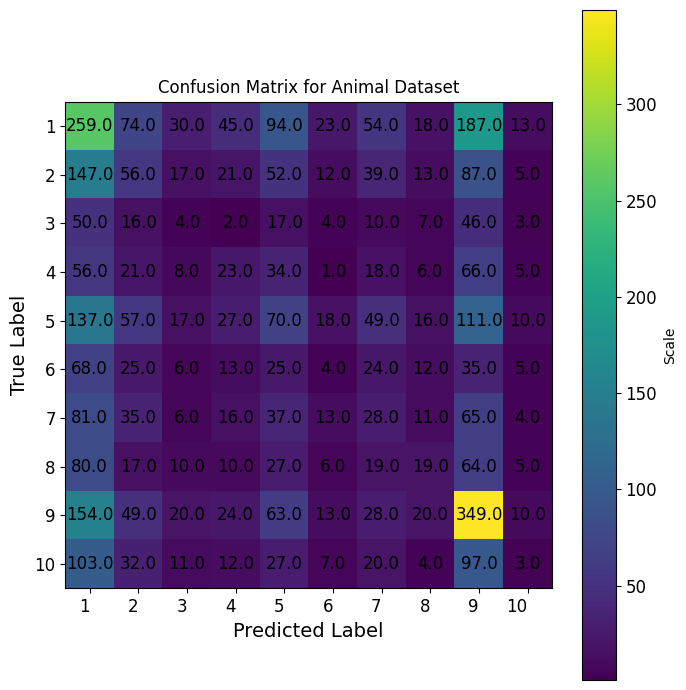

Max depth=14, Impurity criterion=gini
Accuracy : 0.1875
Class wise Precision  : [0.25228311 0.15568862 0.04761905 0.07657658 0.15850144 0.12328767
 0.12440191 0.10471204 0.3125     0.09638554]
Class wise Recall  : [0.27625    0.11529933 0.04375    0.07142857 0.21484375 0.08372093
 0.08724832 0.07843137 0.45765027 0.02555911]
Class wise F1 scores : [0.26372315 0.13248408 0.04560261 0.07391304 0.18242123 0.09972299
 0.1025641  0.0896861  0.3713969  0.04040404]
Overall Precision  : 0.1451955962057103
Overall Recall  : 0.14541816598246834
Overall F1 score : 0.14019182324296578


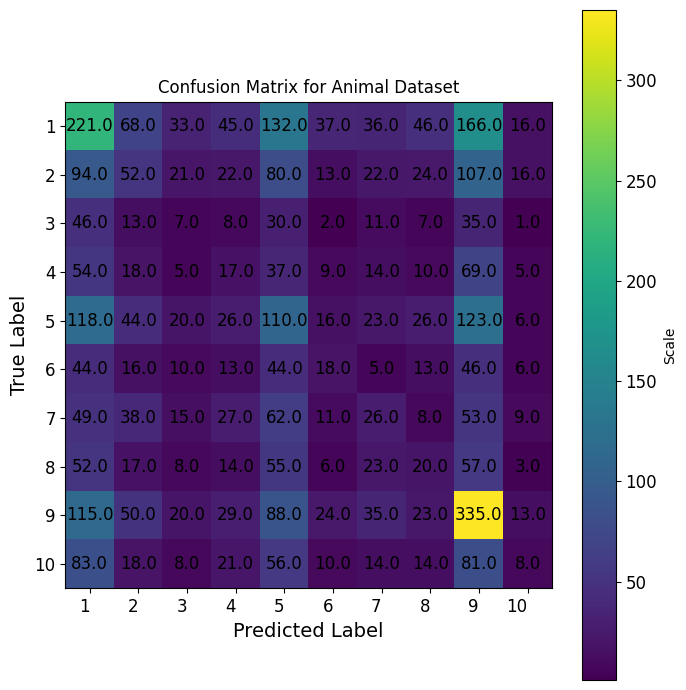

Max depth=14, Impurity criterion=entropy
Accuracy : 0.18
Class wise Precision  : [0.21478382 0.1475     0.09868421 0.08658009 0.13284133 0.08843537
 0.11538462 0.10434783 0.30998249 0.07633588]
Class wise Recall  : [0.19298246 0.13140312 0.0955414  0.08510638 0.14201183 0.06046512
 0.10033445 0.09411765 0.48827586 0.03205128]
Class wise F1 scores : [0.20330033 0.13898704 0.09708738 0.08583691 0.13727359 0.0718232
 0.10733453 0.09896907 0.379218   0.04514673]
Overall Precision  : 0.13748756273470447
Overall Recall  : 0.1422289548371251
Overall F1 score : 0.13649767821972647


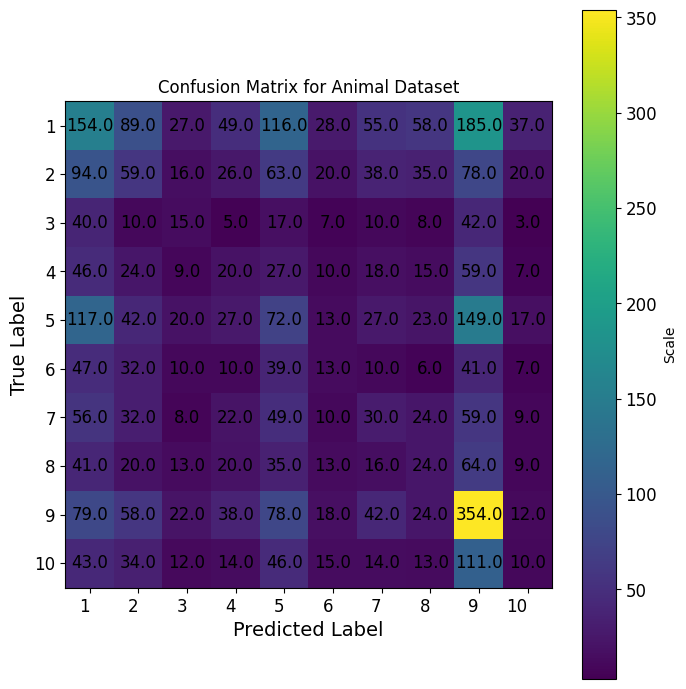

In [10]:

print("Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on Animal Dataset.\n")
for d_max in [ 8,10,12,14 ]:
    for criterion in ['Gini', 'Entropy']:
        dtree = DecisionTree(d_max=d_max, criterion=criterion)
        dtree.fit(xtrain[:4000], ytrain[:4000])
        ypred = dtree.predict(xtest[:4000])
        accuracy = accuracy_score(np.array(ytest[:4000]), np.array(ypred))
        print(f"Max depth={d_max}, Impurity criterion={criterion}")
        confusion_matrix, class_precision, class_recall, class_f1, overall_precision, overall_recall, overall_f1 =  find_metrics(np.array(ypred), np.array(ytest[:4000]))
        # Print evaluation metrics
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision  : {class_precision}")
        print(f"Class wise Recall  : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision  : {overall_precision}")
        print(f"Overall Recall  : {overall_recall}")
        print(f"Overall F1 score : {overall_f1}")
        cf_plot(confusion_matrix , np.unique(ytest[0:4000]), "Animal Dataset")

In [26]:
x=np.load("C:/Users/nilad/Downloads/tfidf_matrix_pca-ed.npy")
y=np.load("C:/Users/nilad/Downloads/tfidf_labels.npy")

print(x.shape,y.shape)
data = np.column_stack((x, y))

# Shuffle the rows of the combined data
np.random.shuffle(data)

# Split the shuffled data into x and y again
shuffled_x = data[:, :-1]  # All columns except the last one are features
shuffled_y = data[:, -1]  
train_ratio = 0.8
num_train_samples = int(train_ratio * len(shuffled_x))

# Extract training and testing sets
xtrain = shuffled_x[:num_train_samples]
xtest = shuffled_x[num_train_samples:]
ytrain = shuffled_y[:num_train_samples]
ytest = shuffled_y[num_train_samples:]

xtrain = xtrain.astype(float)
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
xtest = xtest.astype(float)
print(xtrain.shape,ytrain.shape)


(209527, 100) (209527,)
(167621, 100) (167621,)


In [30]:

print("Applying classification trees using Gini impurity and Entropy as impurity functions with different depths on Text Dataset.\n")
for d_max in [ 8,10,12,14 ]:
    for criterion in ['Gini', 'Entropy']:
        dtree = DecisionTree(d_max=d_max, criterion=criterion)
        dtree.fit(xtrain[:4000], ytrain[:4000])
        ypred = dtree.predict(xtest[:4000])
        accuracy = accuracy_score(np.array(ytest[:4000]), np.array(ypred))
        print(f"Max depth={d_max}, Impurity criterion={criterion}")
        confusion_matrix, class_precision, class_recall, class_f1, overall_precision, overall_recall, overall_f1 =  find_metrics(np.array(ypred), np.array(ytest[:4000]))
        print(f"Accuracy : {accuracy}")
        # print(f"Class wise Precision  : {class_precision}")
        # print(f"Class wise Recall  : {class_recall}")
        # print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision  : {overall_precision}")
        print(f"Overall Recall  : {overall_recall}")
        print(f"Overall F1 score : {overall_f1}\n")
        # cf_plot(confusion_matrix , np.unique(ytest[0:4000]), "Text Dataset")

Applying classification trees using Gini impurity and Entropy as impurity functions with different depths on Text Dataset.

Max depth=8, Impurity criterion=Gini
Accuracy : 0.1775
Overall Precision  : nan
Overall Recall  : 0.07511074905413292
Overall F1 score : nan



C:\Users\nilad\AppData\Local\Temp\ipykernel_22492\509361688.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision[i] = cm[i, i] / np.sum(cm[:, i])
C:\Users\nilad\AppData\Local\Temp\ipykernel_22492\509361688.py:22: RuntimeWarning: invalid value encountered in scalar divide
  f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])


Max depth=8, Impurity criterion=Entropy
Accuracy : 0.1675
Overall Precision  : nan
Overall Recall  : 0.08125487269683737
Overall F1 score : nan

Max depth=10, Impurity criterion=Gini
Accuracy : 0.165
Overall Precision  : nan
Overall Recall  : 0.0779752076346901
Overall F1 score : nan

Max depth=10, Impurity criterion=Entropy
Accuracy : 0.14
Overall Precision  : 0.084376442546936
Overall Recall  : 0.08176015711355096
Overall F1 score : nan

Max depth=12, Impurity criterion=Gini
Accuracy : 0.1425
Overall Precision  : nan
Overall Recall  : 0.07395012193485548
Overall F1 score : nan

Max depth=12, Impurity criterion=Entropy
Accuracy : 0.165
Overall Precision  : 0.08955298903646994
Overall Recall  : 0.0834729613582205
Overall F1 score : nan

Max depth=14, Impurity criterion=Gini
Accuracy : 0.15
Overall Precision  : 0.09071601058566757
Overall Recall  : 0.0841911741415694
Overall F1 score : nan

Max depth=14, Impurity criterion=Entropy
Accuracy : 0.1525
Overall Precision  : 0.084742555105838

# ADABOOST

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def gini(y):
    unique,label_count = np.unique(y,return_counts = True)
    ps = label_count/np.sum(label_count)
    return 1 - np.sum(ps**2)
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [36]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree:
    def __init__(self, d_max, criterion):
        self.d_max = d_max
        self.criterion = criterion
    
    def fit(self, X, y):
        self.class_count = len(np.unique(y))
        self.tree = self.build(X, y, 0)
        
    def build(self, X, y, depth):
        sample_count, feature_count = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.class_count)]
        c_maj = np.argmax(num_samples_per_class)
        if depth == self.d_max or self.class_count == 1:
            return {'leaf': True, 'class': c_maj}
        if sample_count == 0:
            return {'leaf': True, 'class': c_maj}
        if np.all(y == y[0]):
            return {'leaf': True, 'class': y[0]}
        indices = np.arange(feature_count)
        np.random.shuffle(indices)
        indices = indices[:int(np.sqrt(feature_count))]

        if self.criterion == 'Gini':
            best_gini = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    gini_left = 1 - sum((np.sum(y[l_ind] == c) / num_samples_left) ** 2 for c in range(self.class_count))
                    gini_right = 1 - sum((np.sum(y[r_ind] == c) / num_samples_right) ** 2 for c in range(self.class_count))
                    weighted_gini = (num_samples_left / sample_count) * gini_left + (num_samples_right / sample_count) * gini_right
                    if weighted_gini < best_gini:
                        best_gini = weighted_gini
                        best_index = index
                        best_threshold = threshold
                        
        elif self.criterion == 'Entropy':
            best_entropy = np.inf
            for index in indices:
                thresholds = np.unique(X[:, index])
                for threshold in thresholds:
                    l_ind = X[:, index] <= threshold
                    r_ind = X[:, index] > threshold
                    num_samples_left = len(y[l_ind])
                    num_samples_right = len(y[r_ind])
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                    el = -sum((np.sum(y[l_ind] == c) / num_samples_left) * np.log2((np.sum(y[l_ind] == c) / num_samples_left) + 1e-10) for c in range(self.class_count))
                    er = -sum((np.sum(y[r_ind] == c) / num_samples_right) * np.log2((np.sum(y[r_ind] == c) / num_samples_right) + 1e-10) for c in range(self.class_count))
                    weighted_entropy = (num_samples_left / sample_count) * el + (num_samples_right / sample_count) * er
                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_index = index
                        best_threshold = threshold
        l_ind = X[:, best_index] <= best_threshold
        r_ind = X[:, best_index] > best_threshold
        l_tree = self.build(X[l_ind], y[l_ind], depth + 1)
        r_tree = self.build(X[r_ind], y[r_ind], depth + 1)
        return {'leaf': False,
                'index': best_index,
                'threshold': best_threshold,
                'l_tree': l_tree,
                'r_tree': r_tree}

    def predict(self, X):
        return np.array([self.traverse(x, self.tree) for x in X])
    def traverse(self, x, node):
        if node['leaf']:
            return node['class']
        if x[node['index']] <= node['threshold']:
            return self.traverse(x, node['l_tree'])
        else:
            return self.traverse(x, node['r_tree'])

In [63]:

class Adaboost:
    def __init__(self, n_clf=15):
        self.n_clf = n_clf
        self.clfs = []
        self.loss = []
        self.accuracy = []
        self.ensemble_accuracy = []

    def fit(self, X_true, y_true):
        n_samples, n_features = X_true.shape
        k = 2

        # Initialize weights to 1/N
        w = np.ones(n_samples) / n_samples

        self.clfs = []
        self.alphas = []

        # Iterate through classifiers
        for _ in range(self.n_clf):

            idxs = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p = w)
            X = X_true[idxs]
            y = y_true[idxs]

            clf = DecisionTree(criteria = gini,max_depth=8)
            clf.fit(X, y)
            y_pred = clf.predict_classes(X_true)
            e = np.sum(w[y_true!=y_pred])

            # calculate alpha
            EPS =0
            alpha = np.log((1.0 - e + EPS) / (e + EPS)) +10

            # calculate predictions and update weights
            z = (y_true==y_pred)*1

            w *= np.exp(-alpha * z)
            # Normalize to one
            w /= np.sum(w)
            
            y_pred_ensemble = self.predict(X_true)

            # Save classifier
            self.clfs.append(clf)
            self.alphas.append(alpha)
            self.compute_exp_loss(X_true,y_true)
            self.accuracy.append(np.mean(y_pred==y_true))
            self.ensemble_accuracy.append(np.mean(y_pred_ensemble==y_true))
            print("Learner: ",len(self.clfs))
            print("Alpha: ",alpha)
            print("Accuracy of current classifier: ",self.accuracy[-1])
            print("Exp Loss: ",self.loss[-1])
            print("Accuracy of Ensemble classifier till now: ",self.ensemble_accuracy[-1])
            

    def compute_exp_loss(self,X,y):
        y_pred = self.predict(X)
        z = (y==y_pred)*2 - 1
        self.loss.append(np.mean(np.exp(-z)))

    def predict(self, X):
        
        y_pred = np.zeros(len(X))
        pred = np.zeros((len(X),10))
        for i in range(10):
            temp = np.zeros(len(X))
            for j in range(len(self.clfs)):
                y = self.clfs[j].predict_classes(X)
                I = (y == i)
                temp +=  self.alphas[j]*I
            pred[:,i] = temp
        y_pred = np.argmax(pred,axis = 1)
        return y_pred

In [39]:
data=np.load("C:/Users/nilad/Downloads/pca.npz")
print("Keys in the loaded data:", list(data.keys()))
x = np.array(data[list(data.keys())[0]])
y = (data[list(data.keys())[1]])

z = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
num_classes = len(z)
# one_hot_y = np.zeros((len(y), num_classes))
for i, label in enumerate(y):
    label_index = z.index(label)
    y[i] = label_index+1
# y=np.array(one_hot_y)
print(x.shape,y.shape)
data = np.column_stack((x, y))

# Shuffle the rows of the combined data
np.random.shuffle(data)

# Split the shuffled data into x and y again
shuffled_x = data[:, :-1]  # All columns except the last one are features
shuffled_y = data[:, -1]  
train_ratio = 0.8
num_train_samples = int(train_ratio * len(shuffled_x))

# Extract training and testing sets
xtrain = shuffled_x[:num_train_samples]
xtest = shuffled_x[num_train_samples:]
ytrain = shuffled_y[:num_train_samples]
ytest = shuffled_y[num_train_samples:]

xtrain = xtrain.astype(float)/255.0
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
xtest = xtest.astype(float)/255.0
print(xtrain.shape,ytrain.shape)


Keys in the loaded data: ['data', 'labels']
(24209, 512) (24209,)
(19367, 512) (19367,)


In [41]:
clf = Adaboost(n_clf=25)
clf.fit(xtrain[:1000], ytrain[:1000])

Learner:  1
Alpha:  1.656418121471804
Accuracy of current classifier:  0.368
Exp Loss:  1.8533337499372071
Accuracy of Ensemble classifier till now:  0.0
Learner:  2
Alpha:  1.5332435637072943
Accuracy of current classifier:  0.305
Exp Loss:  1.8533337499372071
Accuracy of Ensemble classifier till now:  0.368
Learner:  3
Alpha:  1.2626198316412593
Accuracy of current classifier:  0.279
Exp Loss:  1.825128921289756
Accuracy of Ensemble classifier till now:  0.368
Learner:  4
Alpha:  1.6543772863890909
Accuracy of current classifier:  0.271
Exp Loss:  1.771069666382141
Accuracy of Ensemble classifier till now:  0.38
Learner:  5
Alpha:  1.3488025679965192
Accuracy of current classifier:  0.18
Exp Loss:  1.796924092642305
Accuracy of Ensemble classifier till now:  0.403
Learner:  6
Alpha:  1.6221307328702816
Accuracy of current classifier:  0.268
Exp Loss:  1.7875224830931542
Accuracy of Ensemble classifier till now:  0.392
Learner:  7
Alpha:  1.505894758410507
Accuracy of current classifi

Text(0.5, 1.0, 'Accuracy of Ensemble of Decision Trees in Adaboost Framework')

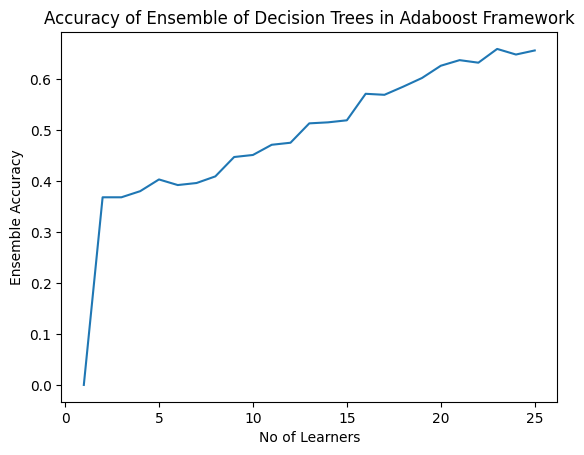

In [44]:
plt.plot(np.arange(1,26),clf.ensemble_accuracy)
plt.xlabel("No of Learners")
plt.ylabel("Ensemble Accuracy")
plt.title("Accuracy of Ensemble of Decision Trees in Adaboost Framework")


Text(0.5, 1.0, 'Loss of Ensemble of Decision Trees in Adaboost Framework')

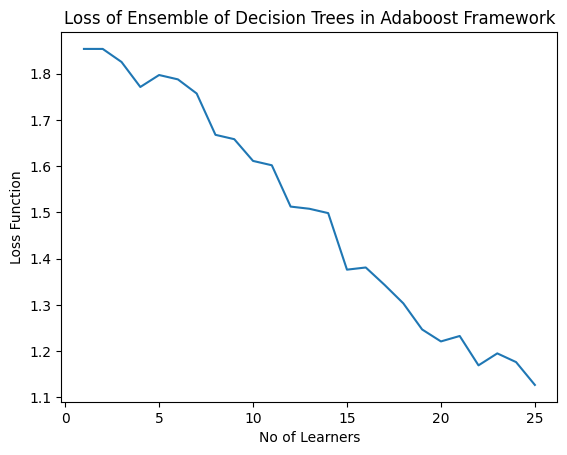

In [43]:
plt.plot(np.arange(1,26),clf.loss)
plt.xlabel("No of Learners")
plt.ylabel("Loss Function")
plt.title("Loss of Ensemble of Decision Trees in Adaboost Framework")

In [58]:
x=np.load("C:/Users/nilad/Downloads/tfidf_matrix_pca-ed.npy")
y=np.load("C:/Users/nilad/Downloads/tfidf_labels.npy")

print(x.shape,y.shape)
data = np.column_stack((x, y))

# Shuffle the rows of the combined data
np.random.shuffle(data)

# Split the shuffled data into x and y again
shuffled_x = data[:, :-1]  # All columns except the last one are features
shuffled_y = data[:, -1]  
train_ratio = 0.8
num_train_samples = int(train_ratio * len(shuffled_x))

# Extract training and testing sets
xtrain = shuffled_x[:num_train_samples]
xtest = shuffled_x[num_train_samples:]
ytrain = shuffled_y[:num_train_samples]
ytest = shuffled_y[num_train_samples:]

xtrain = xtrain.astype(float)
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
xtest = xtest.astype(float)
print(xtrain.shape,ytrain.shape)


(209527, 100) (209527,)
(167621, 100) (167621,)


In [64]:
clf = Adaboost(n_clf=50)
clf.fit(xtrain[:2000], ytrain[:2000])

Learner:  1
Alpha:  9.264550439749364
Accuracy of current classifier:  0.324
Exp Loss:  2.655996165195924
Accuracy of Ensemble classifier till now:  0.0055
Learner:  2
Alpha:  8.74103192045652
Accuracy of current classifier:  0.205
Exp Loss:  2.6101633186438162
Accuracy of Ensemble classifier till now:  0.0265
Learner:  3
Alpha:  8.752654026361963
Accuracy of current classifier:  0.165
Exp Loss:  2.5925353007391587
Accuracy of Ensemble classifier till now:  0.046
Learner:  4
Alpha:  9.156019854891474
Accuracy of current classifier:  0.163
Exp Loss:  2.5525784601552695
Accuracy of Ensemble classifier till now:  0.0535
Learner:  5
Alpha:  8.891774302714472
Accuracy of current classifier:  0.1005
Exp Loss:  2.5373008446378997
Accuracy of Ensemble classifier till now:  0.0705
Learner:  6
Alpha:  9.038864287637983
Accuracy of current classifier:  0.077
Exp Loss:  2.532600039863325
Accuracy of Ensemble classifier till now:  0.077
Learner:  7
Alpha:  8.835532586442417
Accuracy of current clas

Text(0.5, 1.0, 'Accuracy of Ensemble of Decision Trees in Adaboost Framework')

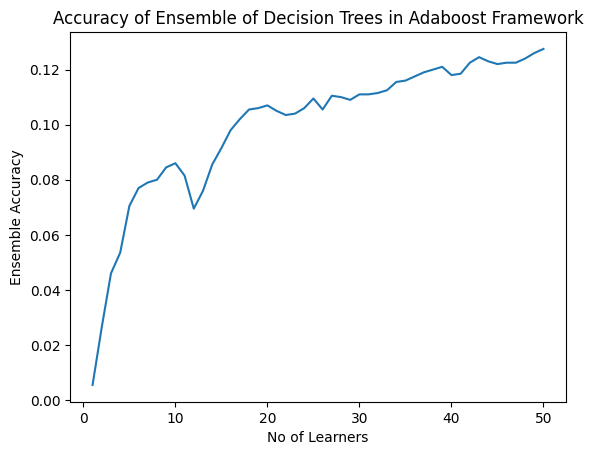

In [66]:
plt.plot(np.arange(1,51),clf.ensemble_accuracy)
plt.xlabel("No of Learners")
plt.ylabel("Ensemble Accuracy")
plt.title("Accuracy of Ensemble of Decision Trees in Adaboost Framework")


Text(0.5, 1.0, 'Loss of Ensemble of Decision Trees in Adaboost Framework')

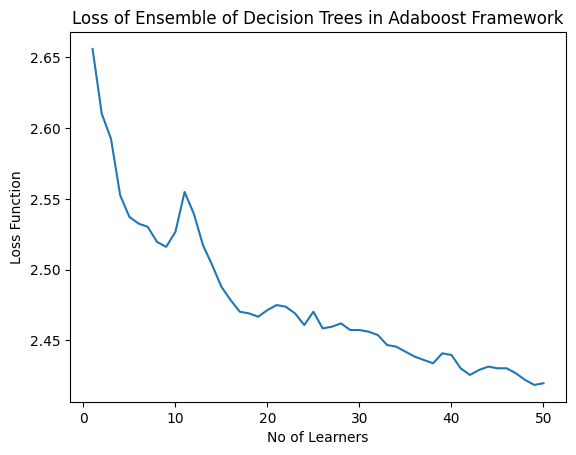

In [67]:
plt.plot(np.arange(1,51),clf.loss)
plt.xlabel("No of Learners")
plt.ylabel("Loss Function")
plt.title("Loss of Ensemble of Decision Trees in Adaboost Framework")

# PCA-MLP-KMEANS

In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class PCA:
    def __init__(self,dim):
        self.dim=dim

    def pca(self,matrix):
        cov = np.cov(matrix, rowvar=False)
        _, eigenvectors = np.linalg.eigh(cov)
        top = eigenvectors[:, -self.dim:]
        features = np.dot(X, top)
        return features

In [ ]:
class ReLU:
  def __init__(self):
    self.map=None

  def forward(self,x):
    mask = (x > 0)
    self.map = mask.astype(int)
    op=self.map*x
    return op

  def back(self,x):
    return x*self.map


In [ ]:
class Dense:
  def __init__(self,inp,out):
    self.inp=inp
    self.out=out
    self.w=np.random.rand(out,inp)
    self.store=None

  def forward(self,x):
    self.store=x
    op=(self.w)@x
    return op

  def back(self,dx,stp=0.01,l=0,b=0):
    z=self.w.T@dx
    self.w=self.w-stp*(dx@(self.store).T+b+l*self.w)
    return z

In [ ]:
class Softmax:
  def __init__(self):
    self.store=None

  def forward(self,x):
    x=x-np.max(x)
    exps = np.exp(x)
    op = exps/np.sum(exps)
    self.store=op
    return op

  def back(self,x):
    softmax_derivative = np.diagflat(self.store) - np.dot(self.store, self.store.T)
    grad = softmax_derivative@x
    return grad

In [ ]:
class MLP:
  def __init__(self,l=0,b=0):
    self.l5=Dense(512,10)
    self.l6=ReLU()
    self.l7=Softmax()
    self.l=l
    self.b=b

  def forward(self,x):
    x=self.l5.forward(x)
    x=self.l6.forward(x)
    x=self.l7.forward(x)
    return x

  def back(self,y,pred,lr=1,reg=None):
    if np.isnan(pred).any():
      return 1000000
    loss=np.sum(-y*np.log(pred+0.000001))
    x = -y/(pred+0.000001)
    if np.isnan(x).any():return loss
    x=self.l7.back(x)
    if np.isnan(x).any():return loss
    x=self.l6.back(x)
    if np.isnan(x).any():return loss
    self.l5.back(x,stp=0.01,l=self.l,b=self.b)

    return loss

  def predict(self,x):
    res=self.forward(x)
    return np.argmax(res)


In [ ]:
def randomTrain(setx,sety,size,classes):
    _,h,w = setx.shape
    x = np.zeros((size,h,w))
    y = np.zeros(size,dtype = int)

    perclass = int(len(sety)/classes)
    new_perclass = int(size/classes)

    for i in range(classes):
        indices =  np.random.permutation(perclass)
        x[i:i+new_perclass,:,:] = np.take(setx[i:i+perclass,:,:], indices[:new_perclass],axis=0)
        y[i:i+new_perclass] = np.take(sety[i:i+perclass], indices[:new_perclass])

    randomize = np.arange(size)
    np.random.shuffle(randomize)
    p,q = x[randomize[0]],y[randomize[0]]
    x = x[randomize]
    y = y[randomize]
    return x,y

In [ ]:
path = '/content/drive/My Drive/pca.npz'
data = np.load(path)
Y=data["labels"].reshape(-1,1)
X=data["data"]
X=X.reshape((X.shape[0],X.shape[1],1))

In [ ]:
permutation = np.random.permutation(len(X))
X = X[permutation]
Y = Y[permutation]
labels = dict({'cane':0,
               'cavallo':1,
               'elefante':2,
               'farfalla':3,
               'gallina':4,
               'gatto':5,
               'mucca':6,
               'pecora':7,
               'ragno':8,
               'scoiattolo':9})
Ylabel = np.zeros(len(Y),dtype = int)
for i in range(Y.shape[0]):
    Ylabel[i] = labels[Y[i][0]]
Y=Ylabel.reshape(-1,1)

sixty=int(X.shape[0]*0.6)
ten=int(X.shape[0]*0.7)
Xtrain=X[:sixty,:]
xval=X[sixty:ten,:]
xtest=X[ten:,:]
Ytrain=Y[:sixty,:]
Yval=Y[sixty:ten,:]
Ytest=Y[ten:,:]
xtrain,yTrain=randomTrain(Xtrain,Ytrain,5000,10)
num_samples = xtrain.shape[0]
ytrain = np.zeros((num_samples, 10))
ytrain[np.arange(num_samples), yTrain.flatten()] = 1

num_samples = Ytest.shape[0]
ytest = np.zeros((num_samples, 10))
ytest[np.arange(num_samples), Ytest.flatten()] = 1

num_samples = Yval.shape[0]
yval = np.zeros((num_samples, 10))
yval[np.arange(num_samples), Yval.flatten()] = 1

In [ ]:
model0 = MLP()

In [ ]:
def f1_score(m):
    tp = np.diag(m).reshape(-1,)
    fn = np.sum(m,axis=1).reshape(-1,)-tp
    fp = np.sum(m,axis=0).reshape(-1,)-tp

    f1 = 2*tp/(2*tp+fp+fn)
    return f1

iteration:  0


<ipython-input-110-ee305d1c6629>:27: RuntimeWarning: divide by zero encountered in log
  los+=np.sum(-y*np.log(pred))
<ipython-input-110-ee305d1c6629>:27: RuntimeWarning: invalid value encountered in multiply
  los+=np.sum(-y*np.log(pred))


iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
Best acc and F1-score On Val-test data:  0.1496626738262426 0.1169789634820481 
 [0.1955836  0.2181146  0.02708804 0.0862423  0.03591682 0.03840878
 0.12030623 0.13039117 0.26951765 0.04822044]


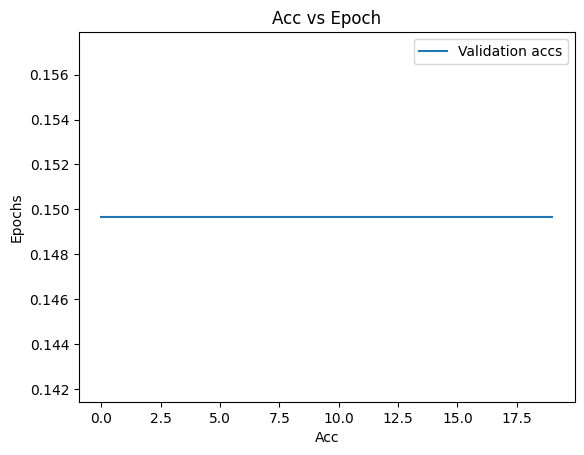

In [ ]:
#f1=2tp/(2tp+fp+fn)
num_classes=10
matrix=np.zeros((num_classes,num_classes))
nm=len(xtrain)
nmval=len(xtest)
Valaccs=[]
Vallosses=[]
Valf1=[]
accs=[]
losses=[]
f1=[]
for j in range(20):
  print("iteration: ",j)
  acc=los=0
  for x,y in zip(xtrain,ytrain):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model0.back(y,pred)
  losses.append(los/nm)
  accs.append(acc/nm)
  acc=los=0
  for x,y in zip(xtest,ytest):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    truth=np.argmax(y)
    prediction=np.argmax(pred)
    matrix[truth,prediction]+=1
    if prediction == truth:
      acc+=1
  f1.append(f1_score(matrix))
  Vallosses.append(los/nmval)
  Valaccs.append(acc/nmval)
  acc=los=0

# print("Best On train data",np.max(accs))
maxind=np.argmax(Valaccs)
print("Best acc and F1-score On Val-test data: ",Valaccs[maxind],np.mean(f1[maxind]),"\n",f1[maxind])

x_values = range(len(accs))
# plt.plot(x_values, accs, label='Training accs')
plt.plot(x_values, Valaccs, label='Validation accs')
plt.xlabel('Acc')
plt.ylabel('Epochs')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()


In [3]:
def dist(vec,typ=1):
  if typ==1:
    return np.linalg.norm(vec, axis=1)
  elif typ==2:
    return np.linalg.norm(vec, axis=1)**2
  elif typ==3:
    return np.sum(np.abs(vec), axis=1)
  elif typ==4:
    return np.sum(np.abs(vec), axis=1)**2


def find_label(strings):
    occurrences = Counter(strings)
    max_occurrence = max(occurrences, key=occurrences.get)
    return max_occurrence

In [4]:
def KMeans(num_clusters,data,y,epsi,typ=1):
    selected_indices = np.random.choice(len(data), num_clusters, replace=False)
    means = data[selected_indices]
    for j in range(100):
      clusters = [[] for _ in range(num_clusters)]
      labels = [[] for _ in range(num_clusters)]
      for i in range(len(data)):
        x=data[i]
        d=dist(means-x,typ)
        assign=np.argmin(d)
        clusters[assign].append(x)
        labels[assign].append(y[i])
      newMeans=np.array([np.mean(c,axis=0) for c in clusters])
      displacement=dist(means-newMeans,typ)
      if displacement.all()<epsi:
        break
      means=newMeans
    meanlabels=[]
    for clstr in labels:
      meanlabels.append(find_label(clstr))
    return means,meanlabels

In [5]:
def KMeansPredict(means,labels,x,typ=1):
  if typ==1:
    d=dist(means-x,typ)
  assign=np.argmin(d)
  return labels[assign]

In [8]:
def testKMeans(m,data,typ):
    clstr=[[]for _ in range(len(m))]
    for i in range(len(data)):
      x=data[i]
      d=dist(m-x,typ)
      assign=np.argmin(d)
      clstr[assign].append(x)
    X = np.vstack((data, m))
    X=X-np.mean(X,axis=0)
    cov_matrix = np.cov(X, rowvar=False)
    _, eigv = np.linalg.eigh(cov_matrix)
    eigv = eigv[:, ::-1]
    eigv = eigv[:, :3]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']


    for k,cl in enumerate(clstr):
        cl=np.array(cl)
        if len(cl)==0:
          continue
        proj=cl@eigv
        ax.scatter(proj[:,0], proj[:,1], proj[:,2], c=colors[k], label=f'Cluster {k+1}')

    ax.set_title('3D Scatter Plot of Clusters')
    ax.legend()
    plt.show()

for num of classes:  3  and metric type:  eucledian


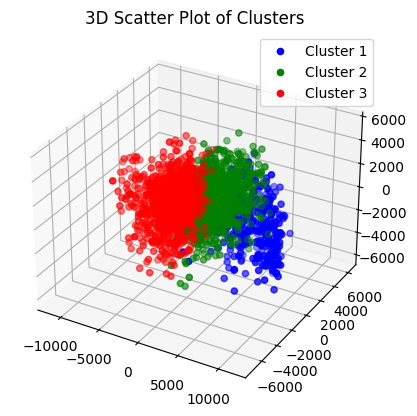

for num of classes:  3  and metric type:  squared eucledian


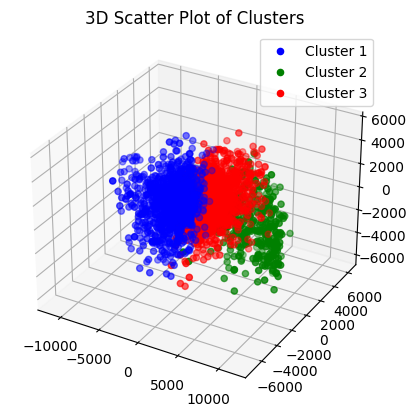

for num of classes:  3  and metric type:  manhattan


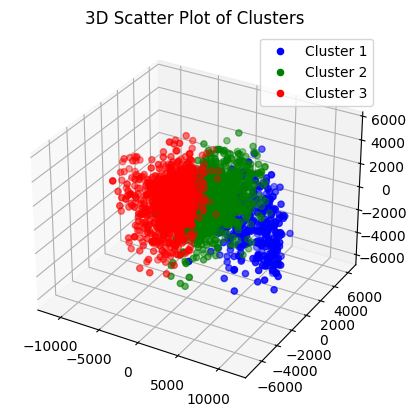

for num of classes:  3  and metric type:  Squared manhattan


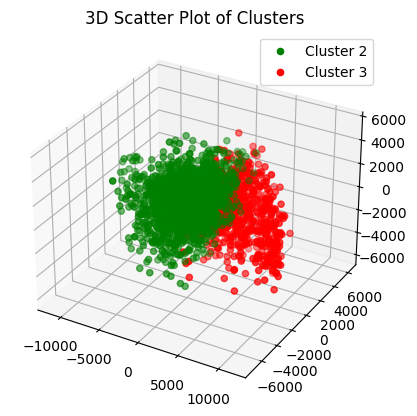

for num of classes:  5  and metric type:  eucledian


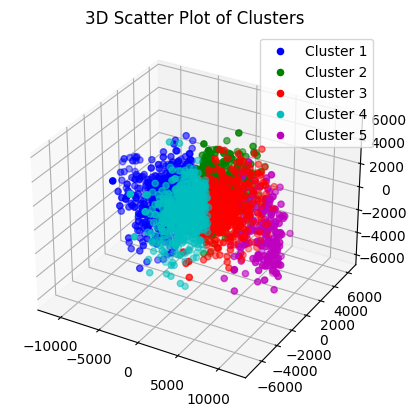

for num of classes:  5  and metric type:  squared eucledian


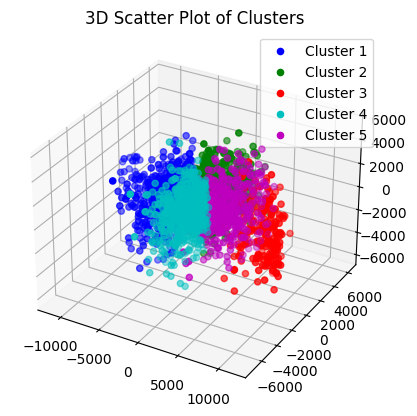

for num of classes:  5  and metric type:  manhattan


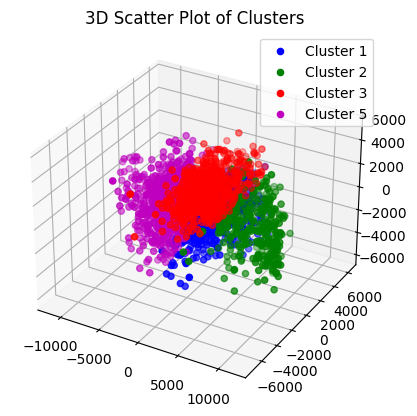

for num of classes:  5  and metric type:  Squared manhattan


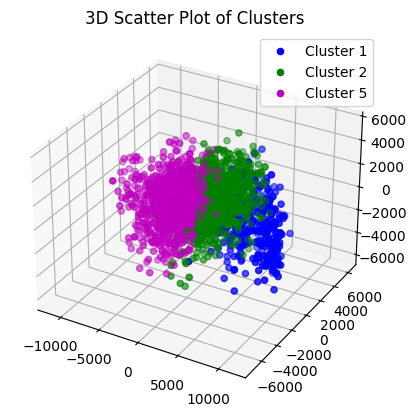

for num of classes:  7  and metric type:  eucledian


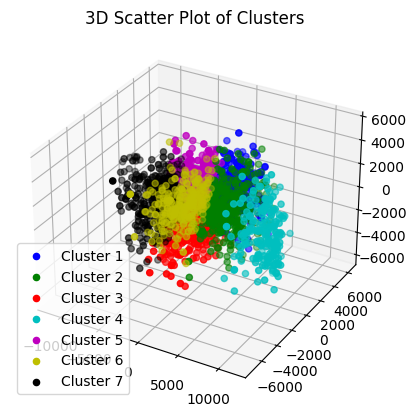

for num of classes:  7  and metric type:  squared eucledian


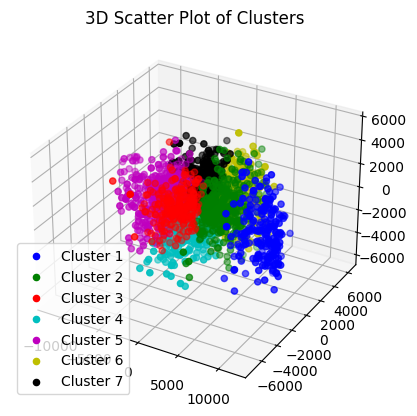

for num of classes:  7  and metric type:  manhattan


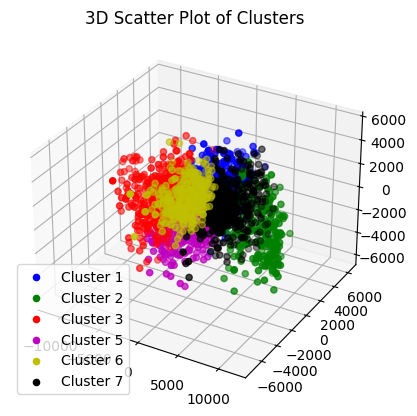

for num of classes:  7  and metric type:  Squared manhattan


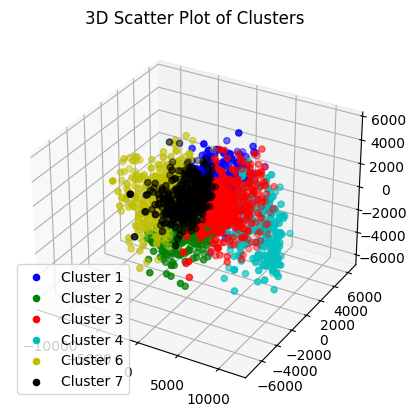

for num of classes:  9  and metric type:  eucledian


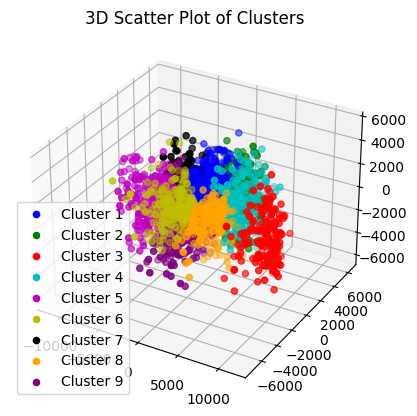

for num of classes:  9  and metric type:  squared eucledian


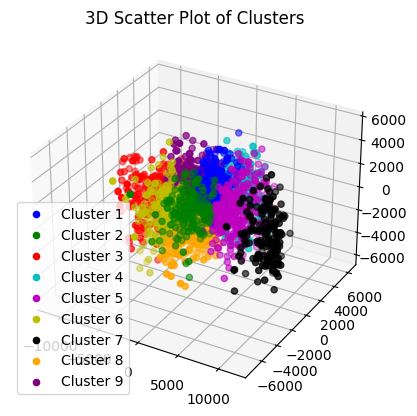

for num of classes:  9  and metric type:  manhattan


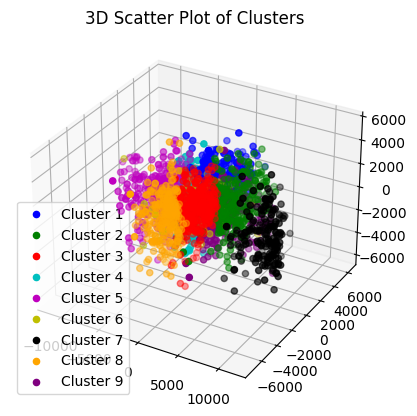

for num of classes:  9  and metric type:  Squared manhattan


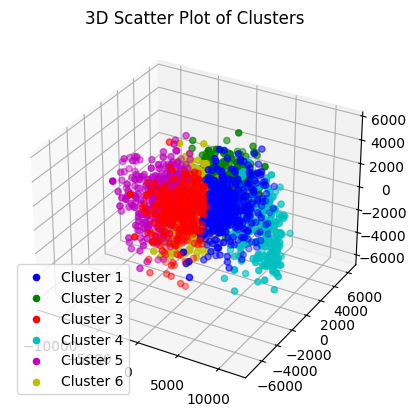

for num of classes:  10  and metric type:  eucledian


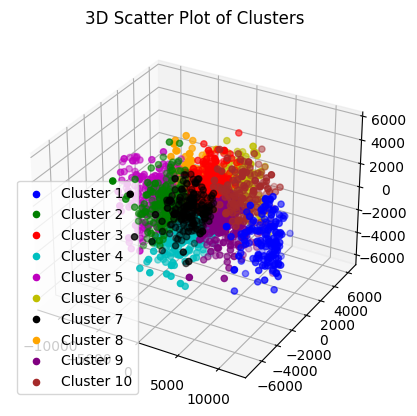

for num of classes:  10  and metric type:  squared eucledian


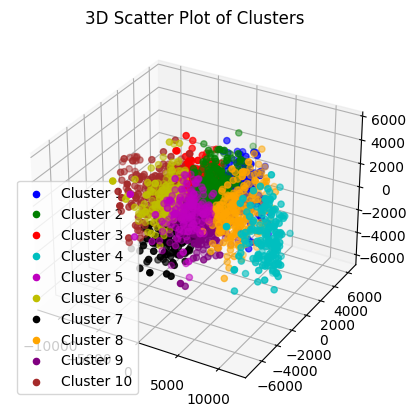

for num of classes:  10  and metric type:  manhattan


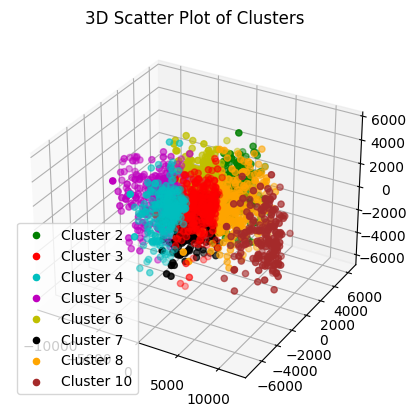

for num of classes:  10  and metric type:  Squared manhattan


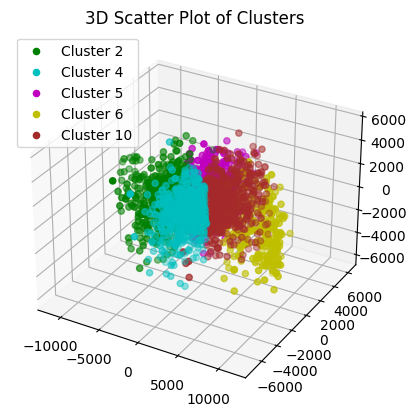

In [9]:
pth='/content/drive/My Drive/pca.npz'
data=np.load(pth)

x=data["data"]
y=data["labels"]

permutation = np.random.permutation(len(y))
x = x[permutation]
y = y[permutation]

division=int(0.9*len(y))
x_val=x[division:]
y_val=y[division:]

x_train=x[:division]
y_train=y[:division]

dis={1:"eucledian",2:"squared eucledian",3:"manhattan",4:"Squared manhattan"}

for num in [3,5,7,9,10]:
    for a in range(1,5):
        print("for num of classes: ",num," and metric type: ",dis[a])
        centers,tags=KMeans(num,x_train,y_train,0.0,a)
        testKMeans(centers,x_val,a)


# CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class SmallConv:
  def __init__(self,inp_channels,num_ker,stride=1,pad=0,ker_size=5):
    self.inp_size=None
    self.ker_size=ker_size
    self.num_ker=num_ker
    self.pad=pad
    self.stride=stride
    self.inp_channels=inp_channels
    self.kernels=np.random.rand(num_ker,inp_channels,ker_size,ker_size)
    self.inp=None

  def patches(self,inp):
        stride = self.stride
        s= self.ker_size
        _,h,w = inp.shape
        x=0
        for i in range(0,h-s,stride):
            y=0
            for j in range(0,w-s,stride):
                im_region = inp[:,i:i+s, j:j+s]
                yield im_region, i,j

  def backpatches(self,inp,stride=None):
        if stride == None:
          stride = self.stride
        s= self.ker_size
        h,w = inp.shape
        x=0
        for i in range(0,h-s,stride):
            y=0
            for j in range(0,w-s,stride):
                im_region = inp[i:i+s, j:j+s]
                yield im_region, i,j

  def forward(self,x):
    k = self.ker_size
    p = self.pad
    s = self.stride
    _,h,w = x.shape
    nk=self.num_ker
    x = np.pad(x, ((0, 0),(p,p),(p,p)), mode='constant', constant_values=0)
    self.inp_size=x.shape
    h = int((h-k+2*p)/s)+1
    w = int((w-k+2*p)/s)+1
    self.inp = x
    output = np.zeros((nk,h,w))
    for z in range(nk):
        for wind,i,j in self.patches(x):
            output[z,i//s,j//s]=np.sum(self.kernels[z]*wind)
    return output


  def back(self,delO,stp=0.01,l=0,b=0):
    p=self.pad
    inp=self.inp
    d=self.stride-1
    ks=self.ker_size
    nk=self.num_ker
    c,h,w=self.inp_size
    inp_ch=self.inp_channels
    num_channels, height, width = delO.shape
    new_height = height + (height - 1) * d
    new_width = width + (width - 1) * d
    dialatedO = np.zeros((num_channels, new_height, new_width))
    dialatedO[:,::d+1,::d+1]=delO[:,:,:]
    delk=np.zeros(self.kernels.shape)
    c,h,w=self.inp_size
    for z in range(nk):
      ker=dialatedO[z,:,:]
      i=0
      for x in range(0,h-new_height):
        j=0
        for y in range(0,w-new_width):
            delk[z,:,i,j]=np.sum(ker*inp[:,x:x+new_height,y:y+new_width])
            j+=1
        i+=1


    pad_dialateO=np.pad(dialatedO, ((0,0),(ks-1,ks-1),(ks-1,ks-1)), mode='constant', constant_values=0)
    delX=np.zeros((c,h,w))
    for z in range(nk):
      channel=pad_dialateO[z,:,:]
      ker=self.kernels[z,:,:]
      for patch,i,j in self.backpatches(channel,1):
        delX[:,i,j]+=np.sum(ker*patch,axis=(1,2))
    outp=delX[:,p:h-p,p:w-p]
    self.kernels=self.kernels-stp*(delk+b+l*self.kernels)
    return outp

In [3]:
class Flatten:
  def __init__(self):
    self.orig_shape=None
  def forward(self,x):
    self.orig_shape = x.shape
    return x.reshape([-1,1])

  def back(self,x):
    op=x.reshape(self.orig_shape)
    #print("flatten back op",op.shape)
    return op


In [4]:
class MaxPool:
  def __init__(self,size=5,stride=1):
    self.size=size
    self.inp=None
    self.stride=stride

  def forward(self,x):
    self.inp=x
    channels,h,w=x.shape
    oph=(h-self.size)//self.stride+1
    opw=(w-self.size)//self.stride+1
    op=np.zeros((channels,oph,opw))
    for z in range(channels):
      for i in range(0,oph):
        for j in range(0,opw):
            ist=i*self.stride
            jst=j*self.stride
            op[z,i,j]=np.max(x[z,ist:ist+self.size,jst:jst+self.size])
    return op

  def back(self,delO):
    channels,_,_=self.inp.shape
    _,h,w=delO.shape
    op=np.zeros(self.inp.shape)
    for z in range(channels):
      for x in range(0,h):
        for y in range(0,w):
            xst=x*self.stride
            yst=y*self.stride
            mask = (self.inp[z, xst:xst+self.size, yst:yst+self.size] == np.max(self.inp[z, xst:xst+self.size, yst:yst+self.size]))
            op[z, xst:xst+self.size, yst:yst+self.size] += mask * delO[z, x, y]
    return op

In [5]:
class ReLU:
  def __init__(self):
    self.map=None

  def forward(self,x):
    mask = (x > 0)
    self.map = mask.astype(int)
    op=self.map*x
    return op

  def back(self,x):
    return x*self.map


In [6]:
class Dense:
  def __init__(self,inp,out):
    self.inp=inp
    self.out=out
    self.w=np.random.rand(out,inp)
    self.store=None

  def forward(self,x):
    self.store=x
    op=(self.w)@x
    return op

  def back(self,dx,stp=0.01,l=0,b=0):
    z=self.w.T@dx
    self.w=self.w-stp*(dx@(self.store).T+b+l*self.w)
    return z

In [7]:
class Softmax:
  def __init__(self):
    self.store=None

  def forward(self,x):
    x=x-np.max(x)
    exps = np.exp(x)
    op = exps/np.sum(exps)
    self.store=op
    return op

  def back(self,x):
    softmax_derivative = np.diagflat(self.store) - np.dot(self.store, self.store.T)
    grad = softmax_derivative@x
    return grad

In [18]:
#50x50, conv:1,32,3,0,5, maxpool:5,3, dense:512,10, epoch:500,20, acc:22%
#50x50, conv:1,64,4,0,7, maxpool:7,4, dense:1600,10 acc:%
class SmallModel:
  def __init__(self,l=0,b=0):
    self.l1=SmallConv(1,32,3,0,5)
    self.l2=MaxPool(5,3)
    self.l3=ReLU()
    self.l4=Flatten()
    self.l5=Dense(512,10)
    self.l6=ReLU()
    self.l7=Softmax()
    self.l=l
    self.b=b

  def forward(self,x):
    x=self.l1.forward(x)
    x=self.l2.forward(x)
    x=self.l3.forward(x)
    x=self.l4.forward(x)
    x=self.l5.forward(x)
    x=self.l6.forward(x)
    x=self.l7.forward(x)
    return x

  def back(self,y,pred,lr=1,reg=None):
    if np.isnan(pred).any():
      return 1000000
    loss=np.sum(-y*np.log(pred))
    x = -y/pred
    if np.isnan(x).any():return loss
    x=self.l7.back(x)
    if np.isnan(x).any():return loss
    x=self.l6.back(x)
    if np.isnan(x).any():return loss
    x=self.l5.back(x,stp=0.01,l=self.l,b=self.b)
    if np.isnan(x).any():return loss
    x=self.l4.back(x)
    if np.isnan(x).any():return loss
    x=self.l3.back(x)
    if np.isnan(x).any():return loss
    x=self.l2.back(x)
    if np.isnan(x).any():return loss
    x=self.l1.back(x,stp=0.01,l=self.l,b=self.b)

    return loss

  def predict(self,x):
    res=self.forward(x)
    return np.argmax(res)


In [9]:
def randomTrain(setx,sety,size,classes):
    _,c,h,w = setx.shape
    x = np.zeros((size,c,h,w))
    y = np.zeros(size,dtype = int)

    perclass = int(len(sety)/classes)
    new_perclass = int(size/classes)

    for i in range(classes):
        indices =  np.random.permutation(perclass)
        x[i:i+new_perclass,:,:,:] = np.take(setx[i:i+perclass,:,:,:], indices[:new_perclass],axis=0)
        y[i:i+new_perclass] = np.take(sety[i:i+perclass], indices[:new_perclass])

    randomize = np.arange(size)
    np.random.shuffle(randomize)
    p,q = x[randomize[0]],y[randomize[0]]
    x = x[randomize]
    y = y[randomize]
    return x,y

In [10]:
path = '/content/drive/My Drive/data.npz'
data = np.load(path)
Y=data["labels"].reshape(-1,1)
X=data["data"]/255
X = np.dot(X[..., :3], [0.299, 0.587, 0.114])
X=X.reshape(-1,1,50,50)

In [11]:
permutation = np.random.permutation(len(X))
X = X[permutation]
Y = Y[permutation]
labels = dict({'cane':0,
               'cavallo':1,
               'elefante':2,
               'farfalla':3,
               'gallina':4,
               'gatto':5,
               'mucca':6,
               'pecora':7,
               'ragno':8,
               'scoiattolo':9})
Ylabel = np.zeros(len(Y),dtype = int)
for i in range(Y.shape[0]):
    Ylabel[i] = labels[Y[i][0]]
Y=Ylabel.reshape(-1,1)

sixty=int(X.shape[0]*0.6)
ten=int(X.shape[0]*0.7)
Xtrain=X[:sixty,:,:,:]
xval=X[sixty:ten,:,:,:]
xtest=X[ten:,:,:,:]
Ytrain=Y[:sixty,:]
Yval=Y[sixty:ten,:]
Ytest=Y[ten:,:]
xtrain,yTrain=randomTrain(Xtrain,Ytrain,5000,10)
num_samples = xtrain.shape[0]
ytrain = np.zeros((num_samples, 10))
ytrain[np.arange(num_samples), yTrain.flatten()] = 1

num_samples = Ytest.shape[0]
ytest = np.zeros((num_samples, 10))
ytest[np.arange(num_samples), Ytest.flatten()] = 1

num_samples = Yval.shape[0]
yval = np.zeros((num_samples, 10))
yval[np.arange(num_samples), Yval.flatten()] = 1

In [24]:
model0 = SmallModel()

In [17]:
def f1_score(m):
    tp = np.diag(m).reshape(-1,)
    fn = np.sum(m,axis=1).reshape(-1,)-tp
    fp = np.sum(m,axis=0).reshape(-1,)-tp

    f1 = 2*tp/(2*tp+fp+fn)
    return f1

iteration:  0


<ipython-input-18-d6790edd9295>:28: RuntimeWarning: divide by zero encountered in log
  loss=np.sum(-y*np.log(pred))
<ipython-input-18-d6790edd9295>:28: RuntimeWarning: invalid value encountered in multiply
  loss=np.sum(-y*np.log(pred))
<ipython-input-18-d6790edd9295>:29: RuntimeWarning: invalid value encountered in divide
  x = -y/pred


iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
Best acc and F1-score On Val-test data:  0.154 0.0653557586341111 
 [0.00719794 0.19185881 0.00293255 0.         0.17452679 0.00733945
 0.08802456 0.00634921 0.14965433 0.02567394]


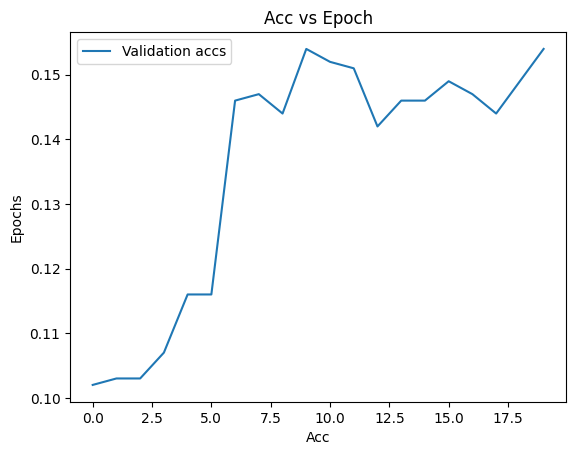

In [25]:
#f1=2tp/(2tp+fp+fn)
num_classes=10
matrix=np.zeros((num_classes,num_classes))

Valaccs=[]
Vallosses=[]
Valf1=[]
accs=[]
losses=[]
f1=[]
for j in range(20):
  print("iteration: ",j)
  acc=los=0
  for x,y in zip(xtrain[:1000],ytrain[:1000]):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model0.back(y,pred)
  losses.append(los/10000)
  accs.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:1000],ytest[:1000]):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    truth=np.argmax(y)
    prediction=np.argmax(pred)
    matrix[truth,prediction]+=1
    if prediction == truth:
      acc+=1
  f1.append(f1_score(matrix))
  Vallosses.append(los/1000)
  Valaccs.append(acc/1000)
  acc=los=0

# print("Best On train data",np.max(accs))
maxind=np.argmax(Valaccs)
print("Best acc and F1-score On Val-test data: ",Valaccs[maxind],np.mean(f1[maxind]),"\n",f1[maxind])

x_values = range(len(accs))
# plt.plot(x_values, accs, label='Training accs')
plt.plot(x_values, Valaccs, label='Validation accs')
plt.xlabel('Acc')
plt.ylabel('Epochs')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()


<img src="https://drive.google.com/uc?id=1RH1M7bVhV3mvruF-DJhElo1XWTkI2cdV" width=400 height=200>